<a href="https://colab.research.google.com/github/Francesca-Rossi/ITA_university_advisor/blob/main/IAuniversity_datset_completo_backup_29_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importazione librerie

In [ ]:
import gspread 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from collections import Counter
from numpy import where
from numpy import mean
from numpy import std
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
import json as js
import seaborn as sns; 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Funzioni principali

In [ ]:
stop_ita = stopwords.words('italian')
stop_en = stopwords.words('english')
stemmer = ItalianStemmer()


#CLEANING DATA
def lang_stop_words(feature, lang):
  if (lang == "IT"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita]) 
  elif (lang == "EN"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en]) 
  else:
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita])
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en])
  return feature

def data_cleaning(feature, regex_list):
  feature=feature.apply(lambda x: x.lower()) #minuscolo
  feature=feature.str.strip() #eliminaz spazi bianchi inizio e fine
  for regex in regex_list:
    feature=feature.str.replace(regex, ' ')
    #feature=feature.str.replace(r'\s\s+', ' ') #eliminaz doppi spazi
  for char in string.punctuation:
    feature=feature.str.replace(char, ' ')
  return feature

#PREPROCESSING TEXT
def preprocessing_text(dataframe, feature, key, lang): 
  feature=feature.str.strip() #elimino spazi bianchi a inizio e fine
  feature =dataframe.apply(lambda row: nltk.word_tokenize(row[key]), axis=1)
  feature =lang_stop_words(feature, lang)
  feature=feature.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  feature=feature.apply(' '.join)
  return feature

#FEATURE ENGINEERING TEXT 
def tf_vector(vectorize, feature):
  tf_matrix = vectorize.fit_transform(feature)
  tf_matrix = tf_matrix.toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(np.round(tf_matrix, 2), columns=vocab)

def bag_of_words(vectorize,feature):
  vectorize.fit(feature)
  bag_array= vectorize.transform(feature).toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(bag_array, columns=vocab)

#FEATURE ENGINEERING CATEGORICAL DATA
encoder = LabelEncoder()
def one_hot_encoding(feature, key):
  genre_labels = encoder.fit_transform(feature) 
  genre_mappings = {index: label for index, label in enumerate(encoder.classes_)}
  feature=genre_labels
  print('encoding', key, ':',  genre_mappings)
  return feature

#TRAINING DATASET
def fit_dataset(model, X_train, y_train, X_test):
  model.fit(X_train, y_train) # training the model on the train dataset
  predictions= model.predict(X_test) # predicting the output on the test dataset
  return predictions

def score_dataset(model, X_train, y_train, X_test, y_test):
  score_dict={}
  score_dict['score_train_set']=model.score(X_train, y_train)
  score_dict['score_test_set']=model.score(X_test, y_test)
  score_dict['lengh_train_set'] = round(len(X_train))
  score_dict['lengh_test_set'] = round(len(X_test))
  return score_dict

def wrong_classification(X_test, predictions, y_test):
  wrong_class=0
  for i in range(len(X_test)):
    elem = X_test[i]
    prediction = predictions[i]
    label = y_test[i]
    if prediction != label:
        wrong_class += 1
        print(i, 'has been classified as ', prediction, 'and should be ', label)
  print("-----------------------------------") 
  return wrong_class

#GRAPHS
# missing value
def missing_value_colors(values, tot):
  clrs=[]
  for x in values:
    x_perc= (x/tot)*100
    if (x_perc<=75):
      clrs.append('g') #green when missing value < 75%
    elif (x_perc>75) and (x_perc<=85):
      clrs.append('y')
    else:
      clrs.append('r')
  return clrs

def missing_value_graphs(dataframe_missing_value, original_df, title):
  #variable
  tot_values=original_df.shape[0] 
  print(tot_values)
  values=dataframe_missing_value.values
  row_index=dataframe_missing_value.index
  start=0
  for i in range(2, 0, -1):
    end=int(len(row_index)/i)
    title_str=f'{title} missing values from {row_index[start]} to {row_index[end-1]}'
    #graphs
    fig, ax = plt.subplots(figsize =(10, 12))
    colors=missing_value_colors(values, tot_values)
    ax.barh(row_index[start:end], values[start:end], color=colors[start:end])   # Horizontal Bar Plot
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)   # Add x, y gridlines
    for i in ax.patches: 
        plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round(((i.get_width()/tot_values)*100), 2))+'%',
                fontsize = 10, fontweight ='bold',color ='grey')   # Add annotation to bars
    ax.invert_yaxis()   # Show top values
    #labeling
    plt.xlabel("Missing values")
    plt.ylabel("Features")
    plt.title(title_str)
    plt.show() #show the graphs
    start=end



#COLLEGAMENTO CON IL GOOGLE SHEET 

In [ ]:
SCOPES = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/big data proj")
cred = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/My Drive/Colab Notebooks/big data proj/GoogleSheetCredentials.json", SCOPES)
gclient = gspread.authorize(cred)
sheet = gclient.open_by_url("https://docs.google.com/spreadsheets/d/1scMc0UlNC1pdZNow5k3pLhofcW6j4ekXyxYlNiBcueI/edit?usp=sharing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RECUPERO FOGLI E SALVATAGGIO IN DATAFRAME

In [ ]:
students_data = sheet.worksheet('Laureando').get_all_records()
graduate_data = sheet.worksheet('Laureato').get_all_records()

In [ ]:
df_students = pd.DataFrame(students_data)
df_graduate = pd.DataFrame(graduate_data)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 88)
graduates shape: (61, 85)


##RIMOZIONE FEATURES RELATIVE AD UN ALTRO PROGETTO

In [ ]:
df_students = df_students.drop(df_students.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
df_graduate = df_graduate.drop(df_graduate.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 79)
graduates shape: (61, 76)


#ANALISI VALORI MANCANTI

##Sostituzione celle vuote con valore 'Nan'

In [ ]:
df_students=df_students.replace('',np.NaN)
df_graduate=df_graduate.replace('',np.NaN)

##Somma valori mancanti per ogni features

In [ ]:
df_missing_value_students=df_students.isnull().sum()
df_missing_value_graduate=df_graduate.isnull().sum()

##STUDENTI: grafico valori mancanti

719


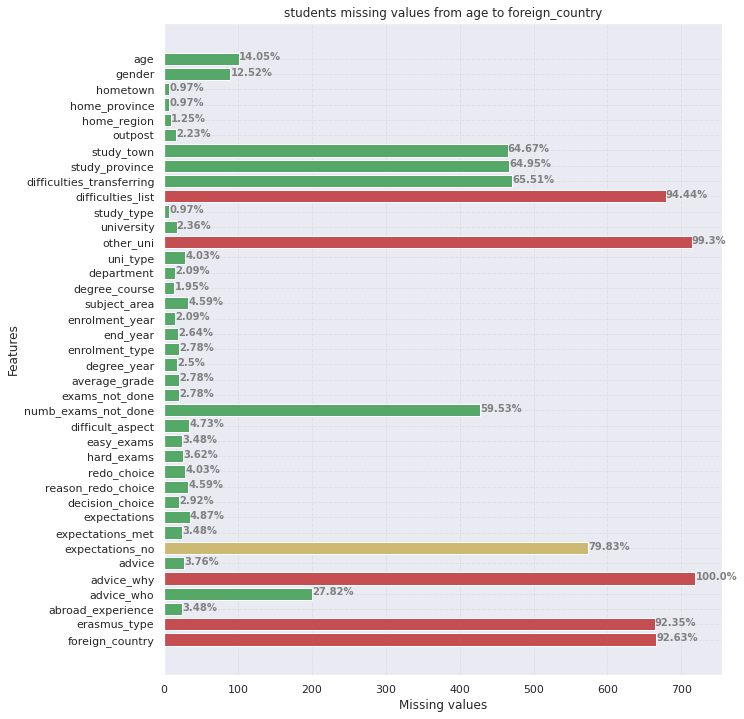

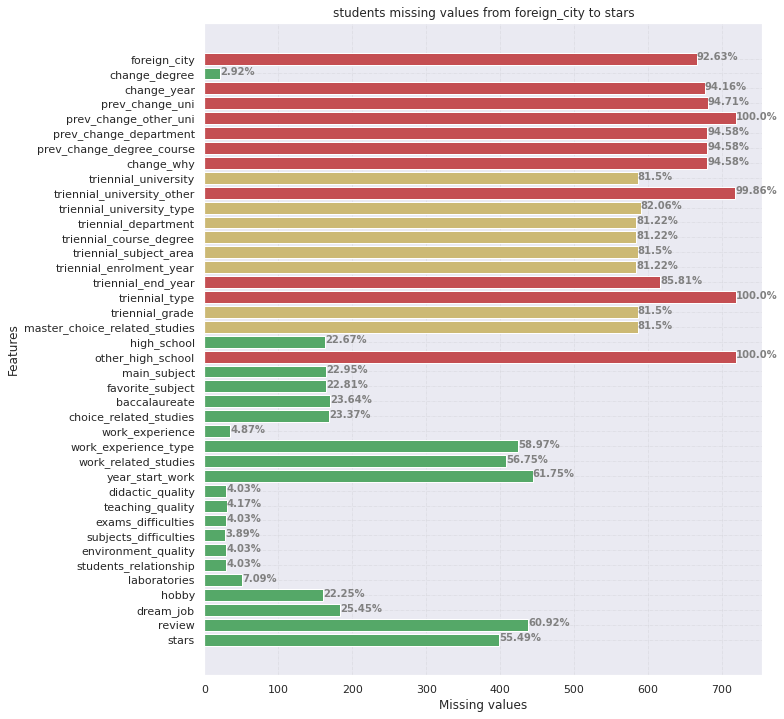

In [ ]:
missing_value_graphs(df_missing_value_students, df_students, 'students')

##LAUREATI: grafico valori mancanti

61


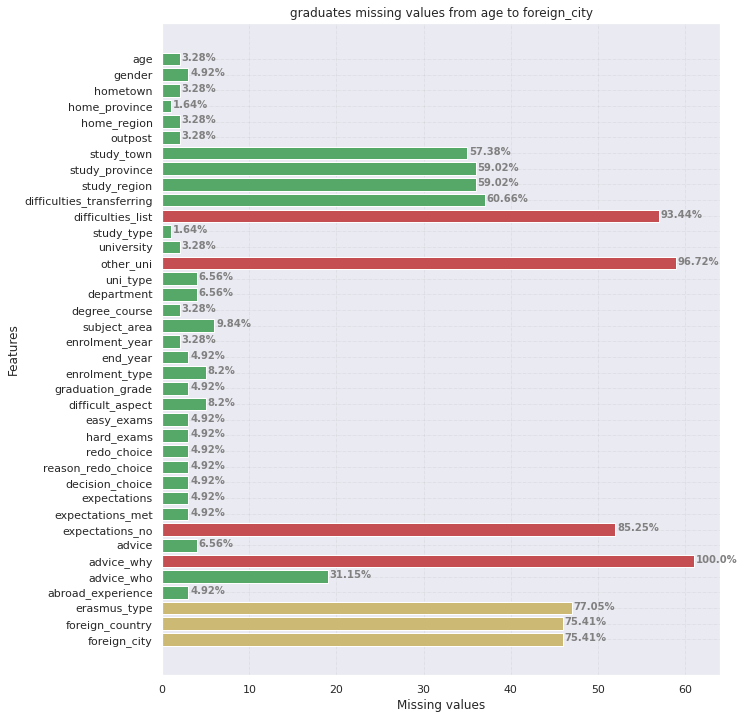

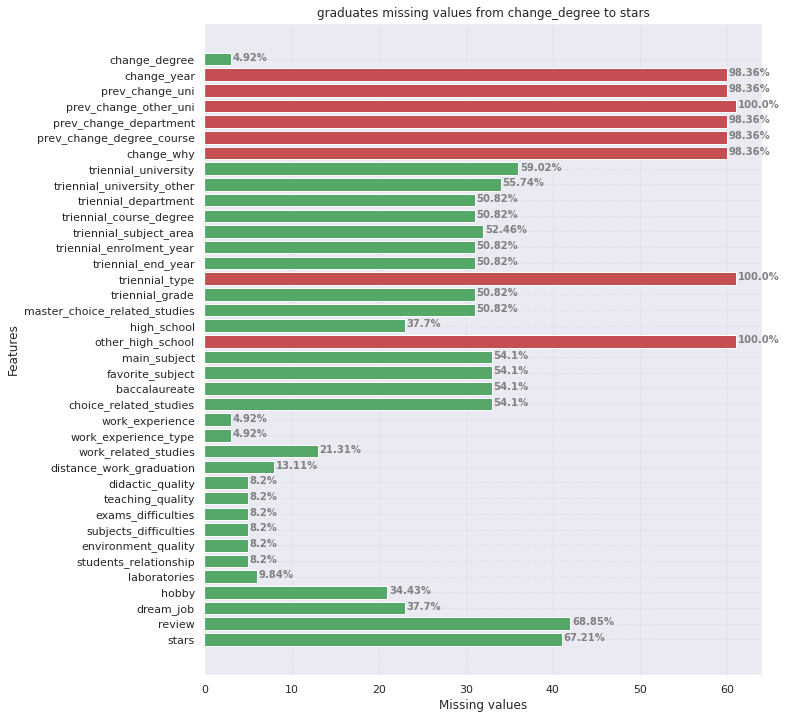

In [ ]:
missing_value_graphs(df_missing_value_graduate, df_graduate, 'graduates')

#GESTIONE VALORI MANCANTI NELLA COLONNA UNIVERSITA'

##Studenti

###1 - Sostituzione altro con valore 'Nan'

In [ ]:
df_students['university']=df_students['university'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
df_students.shape

(719, 79)

In [ ]:
#TODO remove [fra]
df_students[['university', 'other_uni']].head(50) #codice di controllo

university                                   other_uni
0                              Politecnico di MILANO                                         NaN
1       Università degli Studi di NAPOLI Federico II                                         NaN
2         Università degli Studi di ROMA La Sapienza                                         NaN
3         Università degli Studi di ROMA La Sapienza                                         NaN
4                 Università degli Studi di CAGLIARI                                         NaN
5                    Università degli Studi di PARMA                                         NaN
6                                                NaN  Civica Scuola di Cinema "Luchino Visconti"
7                  Università degli Studi di BOLOGNA                                         NaN
8                    Università degli Studi di PARMA                                         NaN
9                    Università degli Studi di PARMA                                         NaN
10  Università degli Studi di MODENA e REGGIO EMILIA                                         NaN
11                 Università degli Studi di PALERMO                                         NaN
12        Università degli Studi di ROMA La Sapienza                                         NaN
13                  Università degli Studi di PADOVA                                         NaN
14                  Università degli Studi di GENOVA                                         NaN
15                  Università degli Studi di MILANO                                         NaN
16                   Università degli Studi di PARMA                                         NaN
17                Università degli Studi di CAGLIARI                                         NaN
18                Università degli Studi di CAGLIARI                                         NaN
19          Università degli Studi di MILANO-BICOCCA                                         NaN
20           Università degli Studi della BASILICATA                                         NaN
21                   Università degli Studi di PARMA                                         NaN
22                 Università degli Studi di BERGAMO                                         NaN
23          Università degli Studi di MILANO-BICOCCA                                         NaN
24                   Università degli Studi di PARMA                                         NaN
25                            Università del SALENTO                                         NaN
26                 Università degli Studi di SALERNO                                         NaN
27                                               NaN                                         NaN
28                                Università di PISA                                         NaN
29        Università degli Studi di ROMA La Sapienza                                         NaN
30                 Università degli Studi di FERRARA                                         NaN
31                   Università degli Studi di PARMA                                         NaN
32                 Università degli Studi di FIRENZE                                         NaN
33   Università Telematica Internazionale UNINETTUNO                                         NaN
34      Università degli Studi di NAPOLI L'Orientale                                         NaN
35                   Università degli Studi di PARMA                                         NaN
36                 Università degli Studi di BOLOGNA                                         NaN
37                  Università degli Studi di GENOVA                                         NaN
38                Università degli Studi di CAGLIARI                                         NaN
39                  Università degli Studi di GENOVA                                         NaN
40                  Università degli Studi di GENOVA             

###2- Merge tra la colonna university e other_uni per unire i valori mancanti in university

In [ ]:
df_students['university']=df_students['university'].combine_first(df_students['other_uni'])
#df_students['university'].head(50)

### 3 - Eliminazione delle righe che nonostante il merge presentano valori nulli nella colonna university

In [ ]:
df_students = df_students[df_students['university'].notna()]
df_students.shape

(696, 79)

##Laureati

### 1- Sostituzione altro con il valore 'Nan'

In [ ]:

df_graduate['university']=df_graduate['university'].replace('altro', np.NaN ) #per poter fare il merge tra due colonne
df_graduate.shape

(61, 76)

In [ ]:
#TODO remove [fra]
df_graduate.isnull().sum() #codice di controllo

age               2
gender            3
hometown          2
home_province     1
home_region       2
                 ..
laboratories      6
hobby            21
dream_job        23
review           42
stars            41
Length: 76, dtype: int64

In [ ]:
#TODO remove [fra]
df_graduate[['university', 'other_uni']].head(50) #codice di controllo

university other_uni
0                     Università degli Studi di PARMA       NaN
1                     Università degli Studi di PARMA       NaN
2                     Università degli Studi di PARMA       NaN
3                     Università degli Studi di PARMA       NaN
4                    Università degli Studi di VERONA       NaN
5    Università degli Studi di MODENA e REGGIO EMILIA       NaN
6                     Università degli Studi di PARMA       NaN
7        Università degli Studi di NAPOLI Federico II       NaN
8                    Università degli Studi di PADOVA       NaN
9         Università degli Studi di ROMA Foro Italico       NaN
10   Università degli Studi di MODENA e REGGIO EMILIA       NaN
11                                 Università di PISA       NaN
12                    Università degli Studi di PARMA       NaN
13         Università degli Studi di ROMA La Sapienza       NaN
14                    Università degli Studi di PARMA       NaN
15                   Università degli Studi di VERONA       NaN
16                    Università degli Studi di PARMA       NaN
17               Università Cattolica del Sacro Cuore       NaN
18                  Università degli Studi di BOLOGNA       NaN
19                   Università degli Studi di MILANO       NaN
20  Libera Università di lingue e comunicazione IU...       NaN
21                   Università degli Studi di MILANO       NaN
22   Università degli Studi di MODENA e REGGIO EMILIA       NaN
23                  Università degli Studi di BERGAMO       NaN
24                  Università degli Studi di TRIESTE       NaN
25           Università degli Studi di MILANO-BICOCCA       NaN
26                    Università degli Studi di PARMA       NaN
27                   Università degli Studi di MILANO       NaN
28           Università degli Studi di MILANO-BICOCCA       NaN
29           Università degli Studi di MILANO-BICOCCA       NaN
30                              Politecnico di MILANO       NaN
31                   Università degli Studi di MILANO       NaN
32  Università degli Studi G d'Annunzio CHIETI-PES...       NaN
33                                 Università di PISA       NaN
34  Università degli Studi Internazionali di ROMA ...       NaN
35  Università degli Studi Internazionali di ROMA ...       NaN
36                  Università degli Studi di PALERMO       NaN
37                  Università degli Studi di BOLOGNA       NaN
38                   Università degli Studi di TRENTO       NaN
39                                                NaN     IUSVE
40                                                NaN     IUSVE
41                    Università degli Studi di PARMA       NaN
42                   Università degli Studi di PADOVA       NaN
43   Università degli Studi di MODENA e REGGIO EMILIA       NaN
44                   Università degli Studi di MILANO       NaN
45         Università degli Studi di ROMA La Sapienza       NaN
46                                Politecnico di BARI       NaN
47                              Politecnico di TORINO       NaN
48         Università degli Studi di ROMA La Sapienza       NaN
49                              Politecnico di MILANO       NaN

### 2- Merge tra colonna university e other_uni

In [ ]:
df_graduate['university']=df_graduate['university'].combine_first(df_graduate['other_uni'])
#df_graduate['university'].head(50)

###3- Eliminazione delle righe che contengono ancora 'Nan' nella colonna university

In [ ]:
df_graduate = df_graduate[df_graduate['university'].notna()]
df_graduate.shape

(57, 76)

#DATI TRIENNALE E MAGISTRALE CICLO UNICO

<p>Selezionare le righe secondo una determinata condizione</p>
<a href="https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/"> https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/</a>

In [ ]:
query_first_degree='study_type == "Triennale" | study_type == "Magistrale_unico"'
df_students_first_degree = df_students.query(query_first_degree)
df_graduate_first_degree = df_graduate.query(query_first_degree)
print('students first degree:',df_students_first_degree.shape)
print('graduates first degree:',df_graduate_first_degree.shape)


students first degree: (557, 79)
graduates first degree: (27, 76)


##ANALISI VALORI MANCANTI

In [ ]:
df_missing_value_first_degree_students=df_students_first_degree.isnull().sum()
df_missing_value_first_degree_graduate=df_graduate_first_degree.isnull().sum()

###STUDENTI TRIENNALE E MAISTRALE A CICLO UNICO:grafico valori mancanti

557


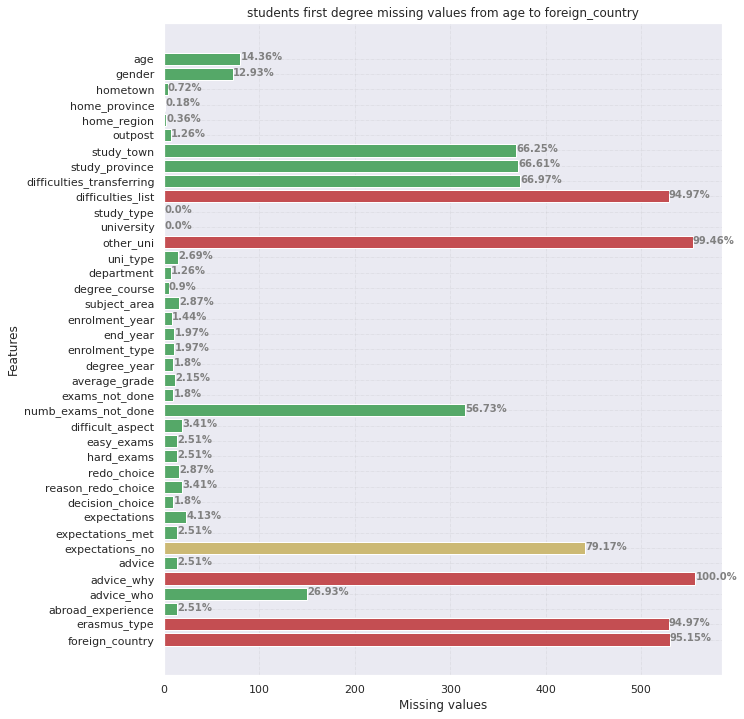

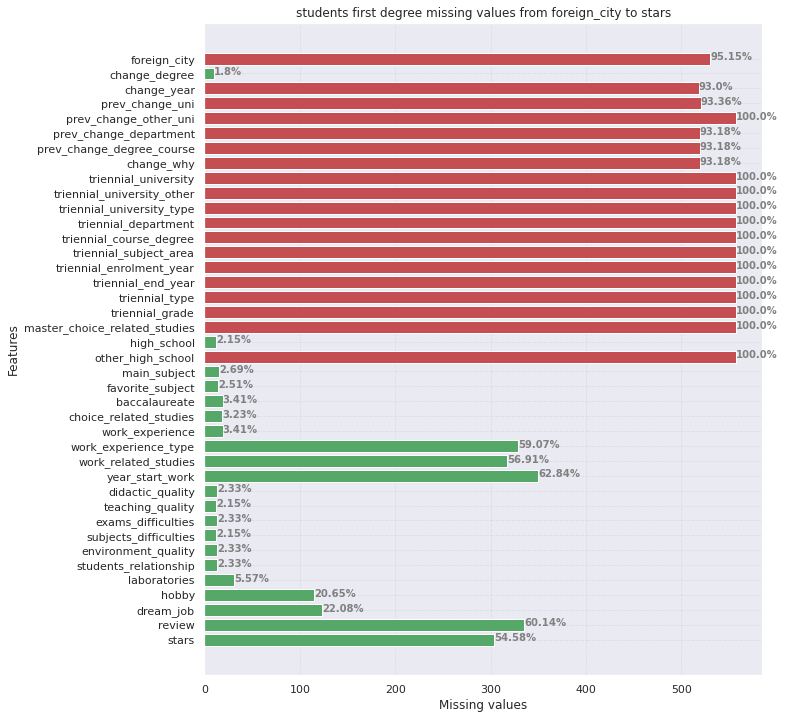

In [ ]:
missing_value_graphs(df_missing_value_first_degree_students, df_students_first_degree, 'students first degree')

###LAUREATI TRIENNALE E MAGISTRALE A CICLO UNICO:grafico valori mancanti

27


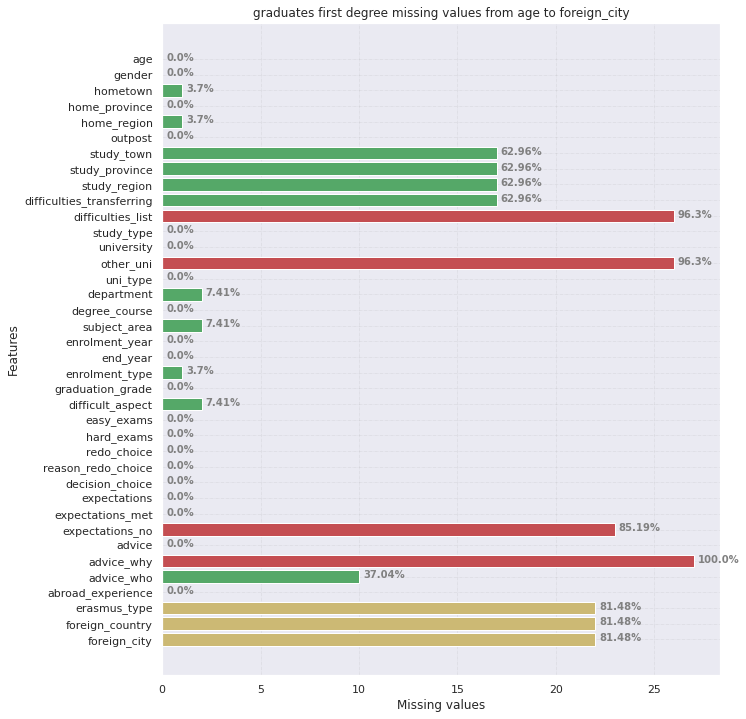

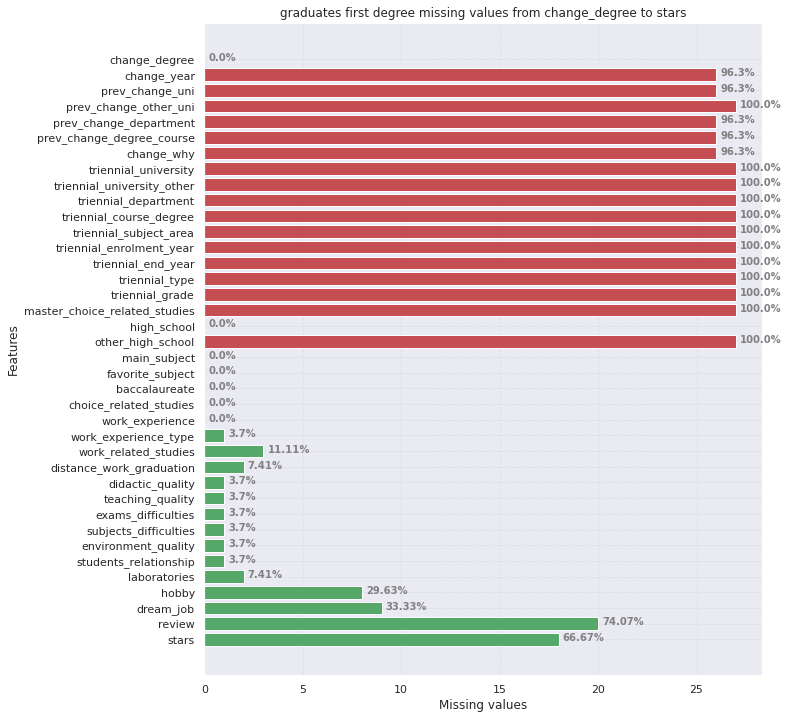

In [ ]:
missing_value_graphs(df_missing_value_first_degree_graduate, df_graduate_first_degree, 'graduates first degree')

##FEATURES SELECTION

In [ ]:
features_first_degree=['degree_course','other_high_school','high_school','main_subject', 'favorite_subject', 'dream_job', 'hobby', 'decision_choice' , 'expectations', 'choice_related_studies'  ]

##Unisco sia gli studenti che i laurati per le feature che ci interessano

In [ ]:
all_features_dict={}
for feature in features_first_degree:
  all_features=df_students_first_degree[feature]
  all_features=all_features.append(df_graduate_first_degree[feature], ignore_index=True, verify_integrity=True)
  all_features_dict[feature]=all_features

df_all_features_first_degree=pd.DataFrame(all_features_dict)
print('original sample firt degree:',df_all_features_first_degree.shape[0] )
df_all_features_first_degree.head()

original sample firt degree: 584


degree_course  ...  choice_related_studies
0  ingegneria aerospaziale  ...                      SI
1     Economia e commercio  ...                      NO
2                 Medicina  ...                      NO
3    Medicina e chirurgia   ...                      NO
4         Infermieristica   ...                      NO

[5 rows x 10 columns]

##GESTIONE VALORI MANCANTI

###eliminazione valori nulli

In [ ]:
#conto valori nulli
df_all_features_first_degree.isnull().sum()

degree_course               5
other_high_school         584
high_school                12
main_subject               15
favorite_subject           14
dream_job                 132
hobby                     123
decision_choice            10
expectations               23
choice_related_studies     18
dtype: int64

In [ ]:
for key in all_features_dict:
  if key!='main_subject' and key!='other_high_school':
    df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree[key].notna()]
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 413


###features main_subject gestione valori mancanti

In [ ]:
school_whitout_subject= df_all_features_first_degree['high_school'].loc[df_all_features_first_degree['main_subject'].isnull()]

In [ ]:
full_subject=df_all_features_first_degree['main_subject']
high_school=np.array(df_all_features_first_degree['high_school'])
for x  in school_whitout_subject:
  subject=np.array(df_all_features_first_degree['main_subject'].loc[df_all_features_first_degree['high_school'].str.contains(x,na=False)][0:1])
  for i in range(0, len(high_school)):
    if (high_school[i]==x):
        full_subject[i]=np.array2string(subject)
df_all_features_first_degree['full_subject']=full_subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
df_all_features_first_degree['main_subject']=df_all_features_first_degree['main_subject'].combine_first(df_all_features_first_degree['full_subject'])
df_all_features_first_degree[['main_subject', 'full_subject']].head(50)

main_subject                                       full_subject
1                           matematica,fisica,scienze                          matematica,fisica,scienze
2                              Greco, latino,italiano                             Greco, latino,italiano
3                             Latino, greco, italiano                            Latino, greco, italiano
4    Greco, latino, italiano, letteratura, filosofia.   Greco, latino, italiano, letteratura, filosofia.
5       Diritto, economia inglese, francese, spagnolo      Diritto, economia inglese, francese, spagnolo
6                       Latino,greco,italiano,inglese                      ['matematica,fisica,scienze']
9                   Matematica,scienze,fisica,chimica                      ['matematica,fisica,scienze']
10                              Economia, informatica                              Economia, informatica
11  Matematica, fisica, italiano, chimica/scienze ...  Matematica, fisica, italiano, chimica/scienze ...
12                       Matematica, fisica, chimica                        Matematica, fisica, chimica 
14                 Scienze umane, filosofia, italiano                 Scienze umane, filosofia, italiano
16  Lingua spagnola, lingua tedesca, lingua ingles...  Lingua spagnola, lingua tedesca, lingua ingles...
17              Economia, diritto, inglese, spagnolo                       ['matematica,fisica,scienze']
19  Microbiologia ambientale, chimica organica ed ...                      ['matematica,fisica,scienze']
20                             Latino, Greco, Scienze                      ['matematica,fisica,scienze']
21                                 Matematica, Fisica                      ['matematica,fisica,scienze']
22           Matematica, Fisica, Informatica, Scienze           Matematica, Fisica, Informatica, Scienze
23           Matematica, scienze, fisica, letteratura           Matematica, scienze, fisica, letteratura
24             Economia aziendale, diritto, le lingue             Economia aziendale, diritto, le lingue
26              Latino, italiano, matematica, scienze              Latino, italiano, matematica, scienze
27  Matematica, scienze, italiano, inglese, fisica...                      ['matematica,fisica,scienze']
28                                Matematica , fisica                                Matematica , fisica
29  Greco, latino, letteratura italiana, storia e ...  Greco, latino, letteratura italiana, storia e ...
32  Visual Arts, Fisica, Matematica, Letteratura I...  Visual Arts, Fisica, Matematica, Letteratura I...
35                  Greco, Latino,Italiano, Filosofia                  Greco, Latino,Italiano, Filosofia
36                         Fisica, matematica, latino                         Fisica, matematica, latino
37  Greco, latino, italiano, storia, filosofia, ma...  Greco, latino, italiano, storia, filosofia, ma...
38                       Matematica, fisica, scienze                        Matematica, fisica, scienze 
40  Italiano, matematica, sistemi, tecnologie di p...  Italiano, matematica, sistemi, tecnologie di p...
42  Informatica, telecomunicazioni, tecnologie e p...  Informatica, telecomunicazioni, tecnologie e p...
43                                             Lingue                                             Lingue
44    Matematica, fisica, scienze, storia e filosofia    Matematica, fisica, scienze, storia e filosofia
45                                        Informatica                                        Informatica
46  Matematica,fisica,scienze,latino,disegno tecni...  Matematica,fisica,scienze,latino,disegno tecni...
47  Greco, latino, letteratura italiana, filosofia...  Greco, latino, letteratura italiana, filosofia...
48  Meccanica, disegno industriale, tecnologia mec...  Meccanica, disegno industriale, tecnologia mec...
49   Italiano, matematica, cucina, inglese, biologia                       ['matematica,fisica,scienze']
50             inglese, francese, spagnolo, filosof

In [ ]:
df_all_features_first_degree=df_all_features_first_degree.drop(['full_subject'], axis=1) #elimino colonna d'appoggio

Eliminazione eventuali valori nulli rimasti ed aggiunta al dizionario con il resto delle colonne pulite

In [ ]:
df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree['main_subject'].notna()] #eliminazioni eventuali valori nulli rimasti
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 412


In [ ]:
original_df_whitout_nan_value=df_all_features_first_degree.copy()

##CLEANING TARGET VARIABLE (degree_course)

In [ ]:
#acronimi
slang_degree_course={"ctf":"chimica e tecnologie farmaceutiche",
       "clemi": "economia e marketing internazionale", 
       "sztpa": "scienze zootecniche e tecnologie delle produzioni animali", 
       "smid": "statistica matematica e trattamento informatico dati", 
       "clei": "economia internazionale",
       "clem": "economia e marketing", 
       "cle": "economia", 
       "dams": "discipline delle arti della musica e dello spettacolo",
       "ctc": "chimica e tecnologie chimiche",
       "pmts": "planning management of tourism systems",
       "eifi":  "lingue moderne comunicazione cooperazione internazionale",
       "lms":  "letteratura musica spettacolo"
        }
regex_degree_course=[r'\sl.*[0-9]+', r'\scurriculum\s.*', r'indirizzo.*', r'[(].*[)]*', r'&', r'\s\s+', r'corso di laurea', r'ciclo unico', r'’']

###eliminazione valori nulli da degree course

In [ ]:
df_all_features_first_degree=df_all_features_first_degree[df_all_features_first_degree['degree_course'].notna()]

###Cleaning valori

In [ ]:
df_all_features_first_degree['degree_course']=data_cleaning(df_all_features_first_degree['degree_course'], regex_degree_course)
#sostituzione slang
for key in slang_degree_course.keys():
  df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains(key), 'degree_course'] = slang_degree_course[key]

#ulteriore pulizia manuale
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('medicina') & ~df_all_features_first_degree['degree_course'].str.contains('veterinaria'), 'degree_course'] = 'medicina e chirurgia'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('informatica') & df_all_features_first_degree['degree_course'].str.contains('elettronica') & df_all_features_first_degree['degree_course'].str.contains('telecomunicazioni') , 'degree_course'] = 'ingegneria informatica elettronica e telecomunicazioni'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('comunicazione e media per le industrie creative'), 'degree_course'] = 'comunicazione e media contemporanei per le industrie creative'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('elettronica') & ~df_all_features_first_degree['degree_course'].str.contains('ingegneria' )& ~df_all_features_first_degree['degree_course'].str.contains('ing'), 'degree_course'] = 'ingegneria elettronica'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('interfacce e tecnologie della comunicazion'), 'degree_course'] = 'interfacce uomo macchina e tecnologie della comunicazione'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('letteratura musica e spettacolo'), 'degree_course'] = 'letteratura musica e spettacolo'
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace(r'(^ingegneria\s*)|(^ingegneria)', 'ing ')
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace('ingeneria ', 'ing ')
df_all_features_first_degree['degree_course']

1                        economia e commercio
2                        medicina e chirurgia
3                        medicina e chirurgia
4                             infermieristica
5      montaggio cinematografico e televisivo
                        ...                  
578                               informatica
579                                      ing 
580                      medicina e chirurgia
581                           scienze motorie
583               beni culturali e spettacolo
Name: degree_course, Length: 412, dtype: object

In [ ]:
df_all_features_first_degree['degree_course']=preprocessing_text(df_all_features_first_degree, df_all_features_first_degree['degree_course'], 'degree_course', 'IT-EN')

In [ ]:
unique_degree_course=np.unique(df_all_features_first_degree['degree_course'])
print(len(unique_degree_course))
print(unique_degree_course)

143
['archeolog' 'architettur' 'arti scienz spettacol' 'autom industrial'
 'ben artist spettacol' 'ben cultural' 'ben cultural spettacol' 'biolog'
 'biolog molecol' 'biotecnolog' 'chimic' 'chimic tecnolog chimic'
 'chimic tecnolog farmaceut' 'civilt lingu stran mod' 'comun'
 'comun med contemporane industr creativ' 'comun med pubblic' 'design'
 'design prodott industrial' 'dietist' 'digital marketing'
 'direzion impres' 'diritt tecnolog' 'disciplin arti music spettacol'
 'econom' 'econom amministr impres' 'econom aziendal' 'econom commerc'
 'econom finanz' 'econom internazional' 'econom management'
 'econom management nuov tecnolog digital'
 'econom marketing internazional' 'econom marketing management'
 'econom merc digital' 'econom merc istitu' 'economì management' 'farmac'
 'filosof' 'fisic' 'food system' 'gestion aziendal' 'giurisprudt'
 'infermierist' 'informat' 'ing' 'ing ambiental' 'ing biomed'
 'ing chimic material' 'ing civil ambiental edil' 'ing edil architettur'
 'ing edil c

##FEATURES CLEANING

###merge high school to other high school




In [ ]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne


In [ ]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].combine_first(df_all_features_first_degree['other_high_school'])

In [ ]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace(np.NaN,'altro')

In [ ]:
df_all_features_first_degree=df_all_features_first_degree.drop(['other_high_school'], axis=1) #elimino colonna d'appoggio
df_all_features_first_degree.head()

degree_course  ... choice_related_studies
1                econom commerc  ...                     NO
2               medicin chirurg  ...                     NO
3               medicin chirurg  ...                     NO
4                  infermierist  ...                     NO
5  montagg cinematograf televis  ...                     NO

[5 rows x 9 columns]

###Controllo finale che non ci siano più valori nulli

In [ ]:
df_all_features_first_degree.isnull().sum()

degree_course             0
high_school               0
main_subject              0
favorite_subject          0
dream_job                 0
hobby                     0
decision_choice           0
expectations              0
choice_related_studies    0
dtype: int64

###Cleaning dei dati

####dataset con dati puliti

In [ ]:
df_clean_features=df_all_features_first_degree.copy()

In [ ]:
categorical_features=['high_school', 'choice_related_studies']
regex_features=[r'\s\s+']
for feature in df_clean_features.columns:
  if feature != 'degree_course':
    df_clean_features[feature]=data_cleaning(df_clean_features[feature], regex_features)
    if feature not in categorical_features:
      df_clean_features[feature]=preprocessing_text(df_clean_features,df_clean_features[feature], feature, 'IT')

In [ ]:
for feature in df_clean_features.columns: 
  display(pd.merge(df_all_features_first_degree[feature], df_clean_features[feature], right_index = True,left_index = True))

degree_course_x               degree_course_y
1                  econom commerc                econom commerc
2                 medicin chirurg               medicin chirurg
3                 medicin chirurg               medicin chirurg
4                    infermierist                  infermierist
5    montagg cinematograf televis  montagg cinematograf televis
..                            ...                           ...
578                      informat                      informat
579                           ing                           ing
580               medicin chirurg               medicin chirurg
581                  scienz motor                  scienz motor
583        ben cultural spettacol        ben cultural spettacol

[412 rows x 2 columns]

high_school_x                 high_school_y
1               Liceo Scientifico             liceo scientifico
2                  Liceo Classico                liceo classico
3                  Liceo Classico                liceo classico
4                  Liceo Classico                liceo classico
5      Istituto tecnico economico    istituto tecnico economico
..                            ...                           ...
578  Istituto tecnico industriale  istituto tecnico industriale
579     Istituto tecnico geometri     istituto tecnico geometri
580             Liceo Scientifico             liceo scientifico
581    Istituto tecnico economico    istituto tecnico economico
583                         IPSIA                         ipsia

[412 rows x 2 columns]

main_subject_x                                     main_subject_y
1                            matematica,fisica,scienze                               matemat fisic scienz
2                               Greco, latino,italiano                                    grec latin ital
3                              Latino, greco, italiano                                    latin grec ital
4     Greco, latino, italiano, letteratura, filosofia.                 grec latin ital letteratur filosof
5        Diritto, economia inglese, francese, spagnolo               diritt econom ingles frances spagnol
..                                                 ...                                                ...
578  Matematica, Italiano, Sistemi e Reti, TPS (Tec...  matemat ital sistem ret tps tecnolog progett s...
579  Costruzioni, topografia, disegno, tecnologia d...     costruzion topograf disegn tecnolog costruzion
580                                           Scienze                                              scienz
581                                        Ragioneria                                            ragioner
583  Disegno per la moda, modellistica e confezione...  disegn mod modellist confezion stor mod stor arte

[412 rows x 2 columns]

favorite_subject_x             favorite_subject_y
1                                           matematica                        matemat
2                                     Non ne avevo una                               
3                                              Latino                           latin
4                                           Filosofia                         filosof
5                                              Diritto                         diritt
..                                                 ...                            ...
578                                         Matematica                        matemat
579                                        costruzioni                     costruzion
580                                        Matematica                         matemat
581                                          Italiano                            ital
583  Disegno per la moda, storia della moda e stori...  disegn mod stor mod stor arte

[412 rows x 2 columns]

dream_job_x                      dream_job_y
1                               consulente finanziario              consulent finanziar
2                                            Radiologo                         radiolog
3                   Diventare un medico specializzato           divent medic specializz
4                        Infermiere di sala operatoria              inferm sal operator
5                           Montatrice cinematografica           montatric cinematograf
..                                                 ...                              ...
578                Lavoro riguardante la CyberSecurity      lavor riguard cybersecurity
579          calcio professionistico (come allenatore)         calc professionist allen
580                                            Medico                             medic
581                                   Palestra salute                       palestr sal
583  Diventare una figurinista di moda o designer d...  divent figurin mod designer mod

[412 rows x 2 columns]

hobby_x                                  hobby_y
1                                          videogiochi                                videogioc
2                        Ascoltare musica, vedere film                    ascolt music ved film
3                                             Atletica                                    atlet
4                         Musica (batteria), biliardo.                     music batter biliard
5                Cinema, viaggi, lettura, arte, musica            cinem viagg lettur arte music
..                                                 ...                                      ...
578           Leggere, ascoltare musica, guardare film             legg ascolt music guard film
579                                    calcio, lettura                              calc lettur
580                                              Nuoto                                     nuot
581                                Fotografia, animali                          fotograf animal
583  Viaggiare, leggere tanto, disegnare moda e asc...  viagg legg tant disegn mod ascolt music

[412 rows x 2 columns]

decision_choice_x             decision_choice_y
1    la mia voglia di intraprendere questo percorso...  vogl intraprend percors stud
2                      La predisposizione alla materia          predisposizion mater
3               Ho sempre voluto fare questo mestiere             sempr vol far mest
4    Il desiderio di poter dare una mano a chi ne h...  desider poter dar man bisogn
5                La mia grande passione per il cinema            grand passion cinem
..                                                 ...                           ...
578                                    I miei genitori                       genitor
579         Era la prosecuzione degli studi precedenti        prosecu stud precedent
580                                                  X                             x
581                                  Il mio interesse                       interess
583      Passione per la storia e la storia dell'arte         passion stor stor arte

[412 rows x 2 columns]

expectations_x                                     expectations_y
1                               quello che sto vivendo                                                viv
2                Di riuscire a proseguire con facilità                                riusc prosegu facil
3    Sicuramente lungo e faticoso ma spero soddisfa...             sicur lung fatic sper soddisfacent fin
4    Tutto quello che ho effettivamente incontrato ...  effett incontr percors fors men mater umanist ...
5    Mi aspettavo di riuscire ad imparare un mestie...           aspett riusc impar mest molt cors pratic
..                                                 ...                                                ...
578              Un approccio metodologico ai problemi                          approcc metodolog problem
579                              Quello che ho trovato                                               trov
580                                                  X                                                  x
581                       Più pratica ma va bene così                                   pratic va ben cos
583                     Materie più attinenti al corso                                mater attinent cors

[412 rows x 2 columns]

choice_related_studies_x choice_related_studies_y
1                         NO                       no
2                         NO                       no
3                         NO                       no
4                         NO                       no
5                         NO                       no
..                       ...                      ...
578                       SI                       si
579                       SI                       si
580                       SI                       si
581                       NO                       no
583                       SI                       si

[412 rows x 2 columns]

##FEATURE ENGINEERING DEGREE COURSE

In [ ]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
vectorize_matrix=tf_vector(tv, df_clean_features['degree_course'])
vectorize_matrix

alimentar  ambient  ambiental  amministr  ...  uman  uom  veterinar  zootecn
0          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
1          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
2          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
3          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
4          0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
..         ...      ...        ...        ...  ...   ...  ...        ...      ...
407        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
408        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
409        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
410        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0
411        0.0      0.0        0.0        0.0  ...   0.0  0.0        0.0      0.0

[412 rows x 142 columns]

In [ ]:
similarity_matrix = cosine_similarity(vectorize_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

0    1    2    3    4    5    6    ...       405  406  407  408  409  410  411
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.358112  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.358112  0.0  0.0  0.0  1.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 412 columns]

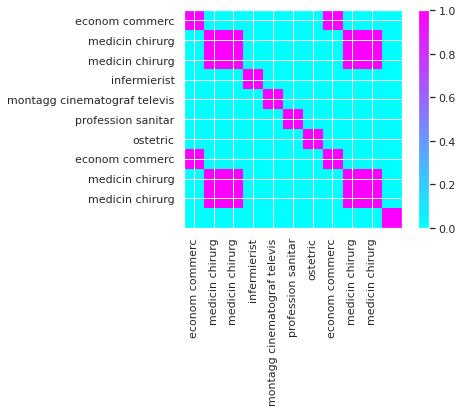

In [ ]:
names=df_clean_features['degree_course'][0:10]
#subjects=['Maths','Hindi','English','Social Studies','Science','Computer Science']
 
plt.xticks(ticks=np.arange(len(names)),labels=names,rotation=90)
plt.yticks(ticks=np.arange(len(names)),labels=names)
# save this plot inside a variable called hm
hm=plt.imshow(similarity_df.loc[0:10, 0:10], cmap='cool',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)

In [ ]:
km = KMeans(n_clusters=120, random_state=0)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels_degree_course = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_clean_features= df_clean_features.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'degree_course',df_clean_features['degree_course'], True)
original_df_whitout_nan_value= original_df_whitout_nan_value.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'full_degree_course',original_df_whitout_nan_value['degree_course'], True)
byCluster=cluster_labels_degree_course.groupby(['ClusterLabel'])


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


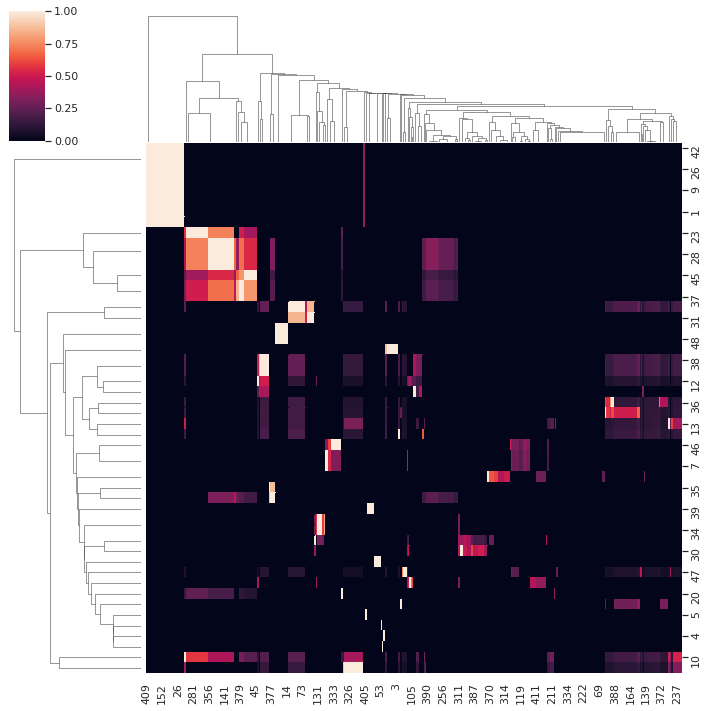

In [ ]:
sns.set_theme(color_codes=True)
g = sns.clustermap(similarity_df[0:50])

In [ ]:
labels = []
for cluster, degree in byCluster:
    print(f"All entries for {cluster!r}")
    print("------------------------")
    print(degree, end="\n\n")   #display(degree)
    labels.append(degree['full_degree_course'].iloc[0])
print(labels)

All entries for 0
------------------------
                                full_degree_course  ... ClusterLabel
33           Mediazione Linguistica Interculturale  ...            0
34           Mediazione linguistica interculturale  ...            0
121          Mediazione linguistica interculturale  ...            0
131         Mediazione linguistica interculturale   ...            0
260  Mediazione Interlinguistica e interculturale   ...            0
378                        Mediazioni linguistiche  ...            0

[6 rows x 3 columns]

All entries for 1
------------------------
        full_degree_course degree_course  ClusterLabel
185  Scienze Motorie  L-22  scienz motor             1
410        Scienze motorie  scienz motor             1

All entries for 2
------------------------
            full_degree_course degree_course  ClusterLabel
28      Ingegneria informatica  ing informat             2
29      Ingegneria Informatica  ing informat             2
32      Ingegneria inf

In [ ]:
df_clean_features=df_clean_features.set_index(cluster_labels_degree_course.index)
df_clean_features['degree_course']=cluster_labels_degree_course['ClusterLabel']
print('check if add missing values:', df_clean_features['degree_course'].isnull().sum())

check if add missing values: 0


#FEATURES ENGINEERING

###Caratteristiche nominali -> choice_related_studies

In [ ]:
for feature in categorical_features:
  df_clean_features[feature]=one_hot_encoding( df_clean_features[feature], feature)

encoding high_school : {0: 'altro', 1: 'ipsia', 2: 'istituto professionale agrario ', 3: 'istituto professionale alberghiero', 4: 'istituto professionale economico ', 5: 'istituto tecnico agrario', 6: 'istituto tecnico alberghiero', 7: 'istituto tecnico economico', 8: 'istituto tecnico geometri', 9: 'istituto tecnico industriale', 10: 'liceo artistico', 11: 'liceo classico', 12: 'liceo linguistico', 13: 'liceo musicale', 14: 'liceo scientifico', 15: 'liceo scienze umane'}
encoding choice_related_studies : {0: 'no', 1: 'si'}


##caratteristiche testuali->bag of words


In [ ]:
#Raggruppo tutte le colonne per il bag of word in un unica e da lista la converto in stringhe
df_clean_features['bag_of_words']=df_clean_features[['main_subject', 'hobby' , 'favorite_subject', 'dream_job' ]].values.tolist()
for index in df_clean_features['bag_of_words'].index:
  item=df_clean_features['bag_of_words'].iloc[index]
  listToStr = ' '.join([str(i) for i in item])
  df_clean_features['bag_of_words'].iloc[index]=listToStr

#df_clean_features['bag_of_words'].head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#addestro il modello
vectorizer_train = CountVectorizer(min_df=0, binary=True)
df_bow_dict=bag_of_words(vectorizer_train, df_clean_features['bag_of_words'])
df_bow_dict

118  3d  abbandon  accadem  accoglit  ...  world  yog  york  zon  zootecn
0      0   0         0        0         0  ...      0    0     0    0        0
1      0   0         0        0         0  ...      0    0     0    0        0
2      0   0         0        0         0  ...      0    0     0    0        0
3      0   0         0        0         0  ...      0    0     0    0        0
4      0   0         0        0         0  ...      0    0     0    0        0
..   ...  ..       ...      ...       ...  ...    ...  ...   ...  ...      ...
407    0   0         0        0         0  ...      0    0     0    0        0
408    0   0         0        0         0  ...      0    0     0    0        0
409    0   0         0        0         0  ...      0    0     0    0        0
410    0   0         0        0         0  ...      0    0     0    0        0
411    0   0         0        0         0  ...      0    0     0    0        0

[412 rows x 906 columns]

In [ ]:
df_clean_features=df_clean_features.drop(['main_subject', 'hobby' , 'favorite_subject', 'dream_job', 'bag_of_words'], axis=1)


In [ ]:
df_clean_features.head() #controllo

degree_course  ...  choice_related_studies
0             52  ...                       0
1              3  ...                       0
2              3  ...                       0
3             16  ...                       0
4            106  ...                       0

[5 rows x 5 columns]

In [ ]:
df_clean_features=df_clean_features.set_index(df_bow_dict.index)
df_clean_features=pd.concat([df_clean_features,  df_bow_dict], axis=1)


In [ ]:
df_clean_features.head()


degree_course  high_school               decision_choice  ... york  zon  zootecn
0             52           14  vogl intraprend percors stud  ...    0    0        0
1              3           11          predisposizion mater  ...    0    0        0
2              3           11            sempr vol far mest  ...    0    0        0
3             16           11  desider poter dar man bisogn  ...    0    0        0
4            106            7           grand passion cinem  ...    0    0        0

[5 rows x 911 columns]

In [ ]:
#df_bow_dict={}
#feature_bow=['main_subject', 'hobby' , 'favorite_subject', 'dream_job' ]
#vectorizer_train = CountVectorizer(min_df=0, binary=True)
#for feature in feature_bow:
  #df_bof=bag_of_words(vectorizer_train, df_clean_features[feature])
  #df_bow_dict[feature]=df_bof
  #df_clean_features=df_clean_features.drop([feature], axis=1)

  #print('sample of', feature , 'after merge row:', df_clean_features.shape[0])
  #print('sample of', feature , 'after merge coloumns:', df_clean_features.shape[1])
  #print('sample  of', feature , 'after bag of words:', df_bof.shape[0])
  #print(df_bow_dict[feature].head())

In [ ]:
#df_clean_features.head()

In [ ]:
#for key in df_bow_dict.keys():
  #print(key)
  #print('columns:', df_bow_dict[key].shape[1])
  #df_clean_features=df_clean_features.set_index(df_bow_dict[key].index)
  #df_clean_features=pd.concat([df_clean_features,  df_bow_dict[key]], axis=1)
  #df_clean_features=pd.merge(df_clean_features, df_bow_dict[key], left_index=True, right_index=True)
  #print(df_clean_features.shape)

In [ ]:
df_clean_features.shape

(412, 911)

In [ ]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
decision_choice           0
expectations              0
choice_related_studies    0
                         ..
world                     0
yog                       0
york                      0
zon                       0
zootecn                   0
Length: 911, dtype: int64

##Caratteristiche testuali-> Tfid

In [ ]:
df_clean_features['tf_if']=df_clean_features[['expectations', 'decision_choice']].values.tolist()
for index in df_clean_features['tf_if'].index:
  item=df_clean_features['tf_if'].iloc[index]
  listToStr = ' '.join([str(i) for i in item])
  df_clean_features['tf_if'].iloc[index]=listToStr


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
df_tf_id=tf_vector(tv, df_clean_features['tf_if'])
df_tf_id

15  2015   25  360  abbast  ...  vot  youtub  zon  zoolog  zootecn
0    0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
1    0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
2    0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
3    0.0   0.0  0.0  0.0    0.26  ...  0.0     0.0  0.0     0.0      0.0
4    0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
..   ...   ...  ...  ...     ...  ...  ...     ...  ...     ...      ...
407  0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
408  0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
409  0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
410  0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0
411  0.0   0.0  0.0  0.0    0.00  ...  0.0     0.0  0.0     0.0      0.0

[412 rows x 1008 columns]

In [ ]:
df_clean_features=df_clean_features.drop(['expectations', 'decision_choice', 'tf_if'], axis=1)

In [ ]:
df_clean_features=df_clean_features.set_index(df_tf_id.index)
df_clean_features=pd.concat([df_clean_features,  df_tf_id], axis=1)

In [ ]:
df_clean_features.head()

degree_course  high_school  choice_related_studies  ...  zon  zoolog  zootecn
0             52           14                       0  ...  0.0     0.0      0.0
1              3           11                       0  ...  0.0     0.0      0.0
2              3           11                       0  ...  0.0     0.0      0.0
3             16           11                       0  ...  0.0     0.0      0.0
4            106            7                       0  ...  0.0     0.0      0.0

[5 rows x 1917 columns]

In [ ]:
df_clean_features.shape

(412, 1917)

In [ ]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
choice_related_studies    0
118                       0
3d                        0
                         ..
vot                       0
youtub                    0
zon                       0
zoolog                    0
zootecn                   0
Length: 1917, dtype: int64

In [ ]:
##########df_tf_id_dict={}
#########feature_tf_id=['expectations', 'decision_choice']
########tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
#######for feature in feature_tf_id:
  ######df_tf_id=tf_vector(tv, df_clean_features[feature])
  #####df_tf_id_dict[feature]=df_tf_id
  ####df_clean_features=df_clean_features.drop([feature], axis=1)

  ###print('sample of', feature , 'after merge row:', df_clean_features.shape[0])
  ##print('sample of', feature , 'after merge coloumns:', df_clean_features.shape[1])
  #print('sample  of', feature , 'after tf if of words:', df_tf_id.shape[0])
  #print(df_tf_id_dict[feature].head())

In [ ]:
####for key in df_tf_id_dict.keys():
  ###print(key)
  ##print('columns:', df_tf_id_dict[key].shape[1])
  #df_clean_features=df_clean_features.set_index(df_tf_id_dict[key].index)
  #df_clean_features=pd.concat([df_clean_features,  df_tf_id_dict[key]], axis=1)
  ##df_clean_features=pd.merge(df_clean_features, df_bow_dict[key], left_index=True, right_index=True)
  #print(df_clean_features.shape)

#DEFINISCO TRAIN SET E TEST SET

In [ ]:
#MAIN SUBJECT DATASET
X=df_clean_features.iloc[:, 1:]
y=df_clean_features['degree_course']



In [ ]:
X

high_school  choice_related_studies  118  3d  ...  youtub  zon  zoolog  zootecn
0             14                       0    0   0  ...     0.0  0.0     0.0      0.0
1             11                       0    0   0  ...     0.0  0.0     0.0      0.0
2             11                       0    0   0  ...     0.0  0.0     0.0      0.0
3             11                       0    0   0  ...     0.0  0.0     0.0      0.0
4              7                       0    0   0  ...     0.0  0.0     0.0      0.0
..           ...                     ...  ...  ..  ...     ...  ...     ...      ...
407            9                       1    0   0  ...     0.0  0.0     0.0      0.0
408            8                       1    0   0  ...     0.0  0.0     0.0      0.0
409           14                       1    0   0  ...     0.0  0.0     0.0      0.0
410            7                       0    0   0  ...     0.0  0.0     0.0      0.0
411            1                       1    0   0  ...     0.0  0.0     0.0      0.0

[412 rows x 1916 columns]

In [ ]:
y

0       52
1        3
2        3
3       16
4      106
      ... 
407     15
408     38
409      3
410      1
411     51
Name: degree_course, Length: 412, dtype: int32

#BILANCIAMENTO DELLE CLASSI: OVERSAMPLE

In [ ]:
print(Counter(y))
oversample = RandomOverSampler(sampling_strategy='auto')
X, y= oversample.fit_resample(X, y)
print(Counter(y))

Counter({3: 30, 2: 20, 7: 18, 15: 17, 5: 15, 6: 13, 14: 10, 12: 10, 13: 9, 16: 8, 51: 8, 22: 7, 26: 7, 20: 7, 34: 6, 0: 6, 25: 6, 41: 6, 50: 6, 28: 5, 31: 5, 55: 5, 23: 5, 39: 5, 68: 4, 32: 4, 33: 4, 46: 4, 8: 4, 65: 4, 10: 4, 19: 4, 57: 4, 42: 3, 98: 3, 73: 3, 47: 3, 104: 3, 36: 3, 40: 3, 67: 3, 74: 3, 27: 3, 43: 3, 30: 3, 29: 3, 52: 2, 44: 2, 17: 2, 45: 2, 60: 2, 37: 2, 49: 2, 59: 2, 63: 2, 61: 2, 76: 2, 62: 2, 96: 2, 72: 2, 58: 2, 56: 2, 66: 2, 71: 2, 53: 2, 95: 2, 1: 2, 116: 2, 79: 2, 38: 2, 70: 2, 64: 2, 75: 2, 84: 2, 35: 2, 106: 1, 115: 1, 109: 1, 48: 1, 88: 1, 18: 1, 85: 1, 24: 1, 80: 1, 69: 1, 93: 1, 99: 1, 54: 1, 92: 1, 108: 1, 83: 1, 9: 1, 103: 1, 119: 1, 111: 1, 81: 1, 101: 1, 107: 1, 94: 1, 102: 1, 114: 1, 11: 1, 89: 1, 97: 1, 112: 1, 21: 1, 118: 1, 90: 1, 86: 1, 117: 1, 82: 1, 105: 1, 77: 1, 110: 1, 87: 1, 78: 1, 113: 1, 91: 1, 4: 1, 100: 1})
Counter({52: 30, 3: 30, 16: 30, 106: 30, 115: 30, 109: 30, 48: 30, 42: 30, 88: 30, 18: 30, 14: 30, 85: 30, 68: 30, 24: 30, 28: 30, 4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#CREAZIONE DEL TRAIN SET E DEL TEST SET

In [ ]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_train_33, X_test_33, y_train_33, y_test_33 = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.50, random_state=42)

In [ ]:
X_train_66, X_test_66, y_train_66, y_test_66 = train_test_split(X, y, test_size=0.66, random_state=42)

In [ ]:
X_train_list=[X_train_20, X_train_33, X_train_50, X_train_66]
y_train_list=[y_train_20, y_train_33, y_train_50, y_train_66]
X_test_list=[X_test_20, X_test_33, X_test_50, X_test_66]
y_test_list=[y_test_20, y_test_33, y_test_50, y_test_66]
keys_list=['test_20%', 'test_33%', 'test_50%', 'test_66%']

#ADDESTRAMENTO E CLASSIFICAZIONE

##Ensemble Voting

In [ ]:
# initializing all the model objects with default parameters

model_1 = MultinomialNB()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = GaussianNB()
estimators_list=[('NB', model_1), ('DT', model_2), ('RF', model_3), ('GB', model_4)]

In [ ]:
# Making the final model using voting classifier
voting_model = VotingClassifier(
    estimators=estimators_list, voting='hard')
  
voting_predict={}
voting_score={}
voting_report={}

In [ ]:
for i in range(0,4):
  voting_predict[keys_list[i]]=fit_dataset(voting_model, X_train_list[i], y_train_list[i], X_test_list[i])
  voting_score[keys_list[i]]=score_dataset(voting_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  voting_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], voting_predict[keys_list[i]], y_test_list[i])
  voting_report[keys_list[i]]=classification_report(y_test_list[i], voting_predict[keys_list[i]], output_dict=True)
  voting_score[keys_list[i]]['accuracy']=voting_report[keys_list[i]]['accuracy']



43 has been classified as  114 and should be  2
199 has been classified as  2 and should be  15
320 has been classified as  15 and should be  2
526 has been classified as  22 and should be  7
603 has been classified as  3 and should be  7
-----------------------------------
14 has been classified as  6 and should be  5
43 has been classified as  12 and should be  2
199 has been classified as  2 and should be  15
320 has been classified as  15 and should be  2
451 has been classified as  2 and should be  51
500 has been classified as  12 and should be  2
523 has been classified as  12 and should be  15
603 has been classified as  22 and should be  7
647 has been classified as  6 and should be  5
804 has been classified as  5 and should be  14
864 has been classified as  12 and should be  15
940 has been classified as  2 and should be  51
974 has been classified as  15 and should be  2
989 has been classified as  51 and should be  15
1005 has been classified as  2 and should be  51
1117 

##Ensemble Bagging 

In [ ]:
# Making the final model using bagging classifier
bagging_model = BaggingClassifier(
    base_estimator=None,n_estimators=10,random_state=0)
  
bagging_predict={}
bagging_score={}
bagging_report={}

In [ ]:
for i in range(0,4):
  bagging_predict[keys_list[i]]=fit_dataset(bagging_model, X_train_list[i], y_train_list[i], X_test_list[i])
  bagging_score[keys_list[i]]=score_dataset(bagging_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  bagging_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], bagging_predict[keys_list[i]], y_test_list[i])
  bagging_report[keys_list[i]]=classification_report(y_test_list[i], bagging_predict[keys_list[i]], output_dict=True)
  bagging_score[keys_list[i]]['accuracy']=bagging_report[keys_list[i]]['accuracy']

11 has been classified as  14 and should be  3
43 has been classified as  114 and should be  2
199 has been classified as  2 and should be  15
278 has been classified as  0 and should be  3
299 has been classified as  76 and should be  5
320 has been classified as  15 and should be  2
500 has been classified as  12 and should be  2
603 has been classified as  23 and should be  7
-----------------------------------
11 has been classified as  41 and should be  3
13 has been classified as  12 and should be  2
14 has been classified as  35 and should be  5
43 has been classified as  47 and should be  2
199 has been classified as  26 and should be  15
299 has been classified as  76 and should be  5
320 has been classified as  13 and should be  2
363 has been classified as  13 and should be  15
446 has been classified as  12 and should be  14
451 has been classified as  115 and should be  51
500 has been classified as  17 and should be  2
523 has been classified as  6 and should be  15
603 h

##Ensemble Boosting

In [ ]:
# Making the final model using boosting classifier
boosting_model = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)
  
boosting_predict={}
boosting_score={}
boosting_report={}

In [ ]:
for i in range(0,4):
  boosting_predict[keys_list[i]]=fit_dataset(boosting_model, X_train_list[i], y_train_list[i], X_test_list[i])
  boosting_score[keys_list[i]]=score_dataset(boosting_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  boosting_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], boosting_predict[keys_list[i]], y_test_list[i])
  boosting_report[keys_list[i]]=classification_report(y_test_list[i], boosting_predict[keys_list[i]], output_dict=True)
  boosting_score[keys_list[i]]['accuracy']=boosting_report[keys_list[i]]['accuracy']

11 has been classified as  50 and should be  3
13 has been classified as  12 and should be  2
22 has been classified as  6 and should be  28
43 has been classified as  6 and should be  2
60 has been classified as  6 and should be  51
61 has been classified as  6 and should be  84
68 has been classified as  6 and should be  84
73 has been classified as  31 and should be  62
93 has been classified as  6 and should be  84
102 has been classified as  31 and should be  62
104 has been classified as  6 and should be  28
105 has been classified as  6 and should be  22
135 has been classified as  6 and should be  33
137 has been classified as  15 and should be  12
152 has been classified as  84 and should be  28
177 has been classified as  31 and should be  62
188 has been classified as  33 and should be  59
197 has been classified as  33 and should be  59
199 has been classified as  6 and should be  15
207 has been classified as  6 and should be  33
242 has been classified as  6 and should be

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11 has been classified as  50 and should be  3
13 has been classified as  12 and should be  2
43 has been classified as  6 and should be  2
60 has been classified as  6 and should be  51
73 has been classified as  31 and should be  62
79 has been classified as  6 and should be  55
102 has been classified as  31 and should be  62
105 has been classified as  6 and should be  22
135 has been classified as  6 and should be  33
150 has been classified as  6 and should be  68
177 has been classified as  31 and should be  62
188 has been classified as  33 and should be  59
197 has been classified as  33 and should be  59
199 has been classified as  12 and should be  15
207 has been classified as  6 and should be  33
218 has been classified as  6 and should be  55
243 has been classified as  35 and should be  6
260 has been classified as  55 and should be  73
262 has been classified as  6 and should be  13
265 has been classified as  6 and should be  13
278 has been classified as  6 and should

##Ensemble Stacking

In [ ]:

stacking_model = StackingClassifier(
    estimators=estimators_list, final_estimator=LogisticRegression())
  
stacking_predict={}
stacking_score={}
stacking_report={}

In [ ]:
for i in range(0,4):
  stacking_predict[keys_list[i]]=fit_dataset(stacking_model, X_train_list[i], y_train_list[i], X_test_list[i])
  stacking_score[keys_list[i]]=score_dataset(stacking_model, X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  stacking_score[keys_list[i]]['wrong_class']=wrong_classification(X_test_list[i], stacking_predict[keys_list[i]], y_test_list[i])
  stacking_report[keys_list[i]]=classification_report(y_test_list[i], stacking_predict[keys_list[i]], output_dict=True)
  stacking_score[keys_list[i]]['accuracy']=stacking_report[keys_list[i]]['accuracy']

14 has been classified as  6 and should be  5
43 has been classified as  16 and should be  2
199 has been classified as  3 and should be  15
278 has been classified as  7 and should be  3
320 has been classified as  15 and should be  2
603 has been classified as  3 and should be  7
647 has been classified as  6 and should be  5
-----------------------------------
14 has been classified as  6 and should be  5
43 has been classified as  12 and should be  2
199 has been classified as  3 and should be  15
320 has been classified as  15 and should be  2
446 has been classified as  7 and should be  14
451 has been classified as  6 and should be  51
500 has been classified as  12 and should be  2
523 has been classified as  2 and should be  15
603 has been classified as  3 and should be  7
647 has been classified as  6 and should be  5
804 has been classified as  7 and should be  14
864 has been classified as  2 and should be  15
905 has been classified as  16 and should be  7
940 has been cl

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##RISULTATI

In [ ]:
print('------------Ensemble voting-------------------')
voting_score_df=pd.DataFrame(voting_score)
display(voting_score_df)
print('------------Ensemble bagging-------------------')
bagging_score_df=pd.DataFrame(bagging_score)
display(bagging_score_df)
print('------------Ensemble boosting-------------------')
boosting_score_df=pd.DataFrame(boosting_score)
display(boosting_score_df)
print('------------Ensemble stacking-------------------')
stacking_score_df=pd.DataFrame(stacking_score)
display(stacking_score_df)

------------Ensemble voting-------------------


test_20%     test_33%     test_50%    test_66%
score_train_set     1.000000     1.000000     1.000000     1.00000
score_test_set      0.993056     0.986532     0.973333     0.93729
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.00000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.00000
wrong_class         5.000000    16.000000    48.000000   149.00000
accuracy            0.993056     0.986532     0.973333     0.93729

------------Ensemble bagging-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     1.000000     1.000000     0.999444     0.999183
score_test_set      0.988889     0.977273     0.963333     0.931818
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class         8.000000    27.000000    66.000000   162.000000
accuracy            0.988889     0.977273     0.963333     0.931818

------------Ensemble boosting-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     0.948264     0.953980     0.940556     0.963235
score_test_set      0.930556     0.910774     0.896667     0.887205
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class        50.000000   106.000000   186.000000   268.000000
accuracy            0.930556     0.910774     0.896667     0.887205

------------Ensemble stacking-------------------


test_20%     test_33%     test_50%     test_66%
score_train_set     1.000000     1.000000     1.000000     0.995915
score_test_set      0.990278     0.983165     0.971111     0.930976
lengh_train_set  2880.000000  2412.000000  1800.000000  1224.000000
lengh_test_set    720.000000  1188.000000  1800.000000  2376.000000
wrong_class         7.000000    20.000000    52.000000   164.000000
accuracy            0.990278     0.983165     0.971111     0.930976

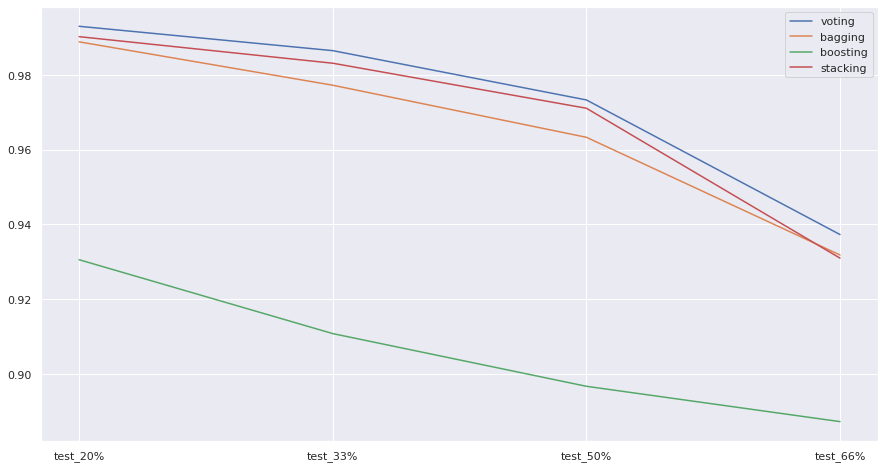

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(voting_score_df.columns,list(voting_score_df.loc['accuracy']))
plt.plot(bagging_score_df.columns,list(bagging_score_df.loc['accuracy']))
plt.plot(boosting_score_df.columns,list(boosting_score_df.loc['accuracy']))
plt.plot(stacking_score_df.columns,list(stacking_score_df.loc['accuracy']))
plt.legend(['voting', 'bagging', 'boosting','stacking'])
plt.show()

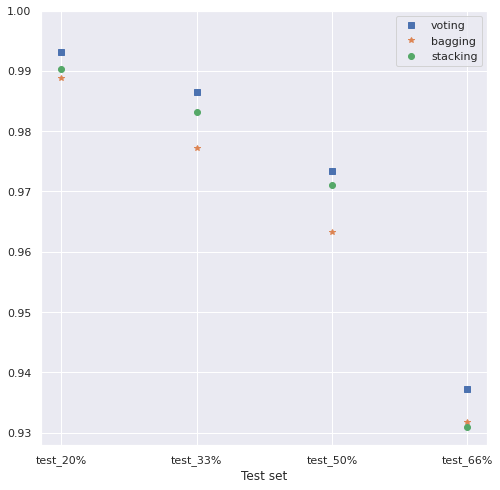

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(voting_score_df.columns,list(voting_score_df.loc['accuracy']), 's')
plt.plot(bagging_score_df.columns,list(bagging_score_df.loc['accuracy']), '*')
plt.plot(stacking_score_df.columns,list(stacking_score_df.loc['accuracy']),'o')
plt.legend(['voting', 'bagging', 'stacking'])
plt.axis(ymax=1)
plt.xlabel("Test set")
plt.show()

#SCELTA DEL MODELLO

In [ ]:
#creazione del dataframe delle accurancy
list_score=[voting_score_df, bagging_score_df, boosting_score_df, stacking_score_df]
name_list=['voting', 'bagging', 'boosting', 'stacking']
accurancy_df=pd.DataFrame()
for i in range(0,4):
  df=list_score[i].transpose()
  label=name_list[i]
  accurancy_df.insert(0, label, df['accuracy'])
accurancy_df

stacking  boosting   bagging    voting
test_20%  0.990278  0.930556  0.988889  0.993056
test_33%  0.983165  0.910774  0.977273  0.986532
test_50%  0.971111  0.896667  0.963333  0.973333
test_66%  0.930976  0.887205  0.931818  0.937290

In [ ]:
df2=accurancy_df.transpose()
dict2={}
l=[]
for key in keys_list:
  dict2[key]=df2[df2[key]==df2[key].max()][key].to_dict() #dizionario contenente per ciascun test set l'algoritmo con l'accurancy più elevata
  l.append(list(dict2[key].values())) #lista di appoggio
#trovo il test set con la migliore accuracy
max_model=max(l) 
for test, sub_dict in  dict2.items():
  if(list(sub_dict.values())==a): #mi faccio restituire l'algoritmo e il test set migliore
    for model, value in sub_dict.items():
      model_name=model
      test_name=test
print('Il miglior modello è', model_name, ', utilizzando un', test_name)


Il miglior modello è voting , utilizzando un test_20%


In [ ]:
if model_name=='voting':
  clf=voting_model
  report=voting_report[test_name]
  predictions=voting_predict[test_name]
  print('1')
elif model_name=='bagging':
  clf=bagging_model
  report=bagging_report[test_name]
  predictions=bagging_predict[test_name]
  print('2')
elif model_name=='boosting':
  clf=boosting_model
  report=boosting_report[test_name]
  predictions=boosting_predict[test_name]
  print('3')
elif model_name=='stacking':
  clf=stacking_model
  report=stacking_report[test_name]
  predictions=stacking_predict[test_name]
  print('4')
else:
  print('Errore nella scelta del modello')

1


In [ ]:
#recupero l'indice corretto per le liste 
def get_index_from_test(test_name, name_list):
  c=0
  for key in name_list:
    if key==test_name:
      return c
    c+=1
index=get_index_from_test(test_name, keys_list)
index

0

#VALUTAZIONE DEL MODELLO

In [ ]:
index_report=[]
report_precision=[]
report_recall=[]
report_f1=[]
report_support=[]
for i in range(0,120):
  item=str(i)
  report_precision.append(report[item]['precision'])
  report_recall.append(report[item]['recall'])
  report_f1.append(report[item]['f1-score'])
  report_support.append(report[item]['support'])
  index_report.append(i)




report_df=pd.DataFrame(report_precision, index=labels, columns=['precision'])
report_df.insert(len(report_df.columns), 'recall', report_recall)
report_df.insert(len(report_df.columns), 'f1-score', report_f1)
report_df.insert(len(report_df.columns), 'support', report_support)
report_df.head(50)

precision  ...  support
Mediazione Linguistica Interculturale                1.000000  ...        9
Scienze Motorie  L-22                                1.000000  ...       10
Ingegneria informatica                               0.666667  ...        4
Medicina                                             0.888889  ...        8
Ingegneria logistica e della Produzione              1.000000  ...        6
Scienze zootecniche e tecnologie delle produzio...   1.000000  ...        6
Scienze Biologiche                                   1.000000  ...        5
Scienze e tecniche psicologiche                      1.000000  ...        7
Beni Culturali                                       1.000000  ...        9
Clei                                                 1.000000  ...        6
Lingue e culture europee                             1.000000  ...        7
Marketing e organizzazione d’impresa                 1.000000  ...        3
Ingegneria Informatica elettronica e delle tele...   1.000000  ...        7
Ingegneria dei Sistemi Informativi                   1.000000  ...       11
Giurisprudenza                                       1.000000  ...        3
Informatica                                          0.800000  ...        5
Infermieristica                                      1.000000  ...        7
Logopedia                                            1.000000  ...        5
Scienze e tecnologie per l'ambiente                  1.000000  ...       10
Letteratura Musica e Spettacolo (LMS)                1.000000  ...        6
Ingegneria gestionale                                1.000000  ...        7
Scienze dell'educazione                              1.000000  ...        6
Scienze della comunicazione                          0.666667  ...        2
Lettere moderne                                      1.000000  ...        7
Lingue, letterature e studi interculturali           1.000000  ...        5
Fisica                                               1.000000  ...        4
Economia aziendale                                   1.000000  ...        8
Scienze della formazione primaria                    1.000000  ...        9
Biotecnologie                                        1.000000  ...        8
Economia e management                                1.000000  ...        8
Chimica e Tecnologia Farmaceutiche                   1.000000  ...        9
Design del prodotto industriale                      1.000000  ...        4
scienze politiche relazioni internazionali e di...   1.000000  ...        4
ingegneria meccanica                                 1.000000  ...        6
Biologia                                             1.000000  ...        5
Medicina Veterinaria                                 1.000000  ...        8
ECONOMIA                                             1.000000  ...        4
Comunicazione, media e pubblicità                    1.000000  ...        4
Ingegneria                                           1.000000  ...        2
Lingue e letterature straniere                       1.000000  ...        6
Farmacia                                             1.000000  ...        3
Scienze e tecnologie alimentari                      1.000000  ...        6
Turismo culturale                                    1.000000  ...        7
Ingegneria edile e delle costruzioni                 1.000000  ...        6
Statistica matematica e trattamento informatico...   1.000000  ...        7
Scienza dei materiali                                1.000000  ...        8
digital marketing                                    1.000000  ...        5
Scienze naturali                                     1.000000  ...        6
Scienze e tecnologie informatiche                    1.000000  ...        6
Lingue per l’impresa                                 1.000000  ...       10

[50 rows x 4 columns]

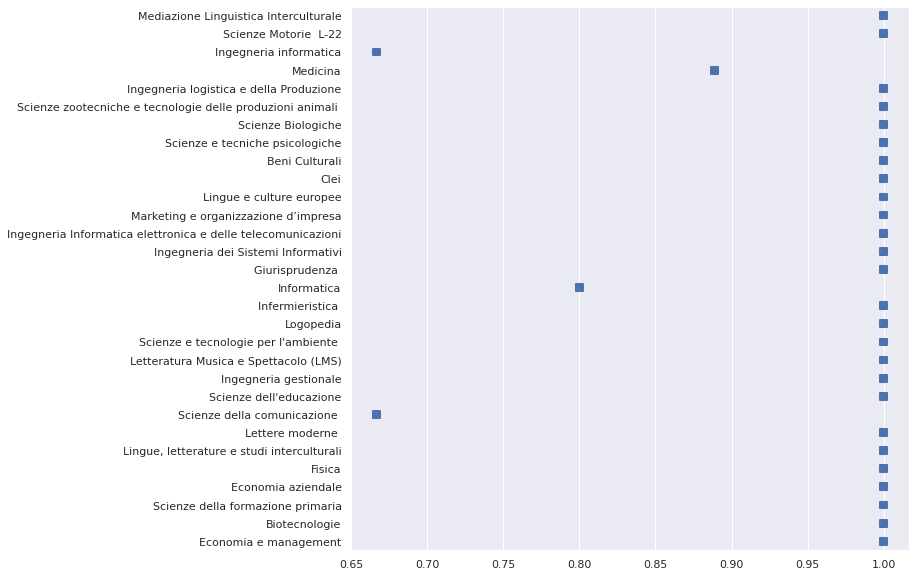

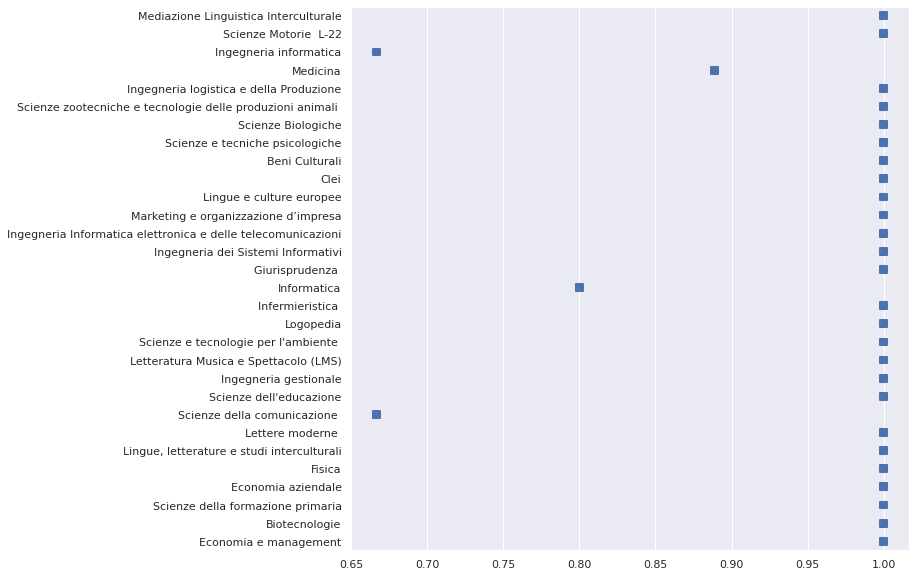

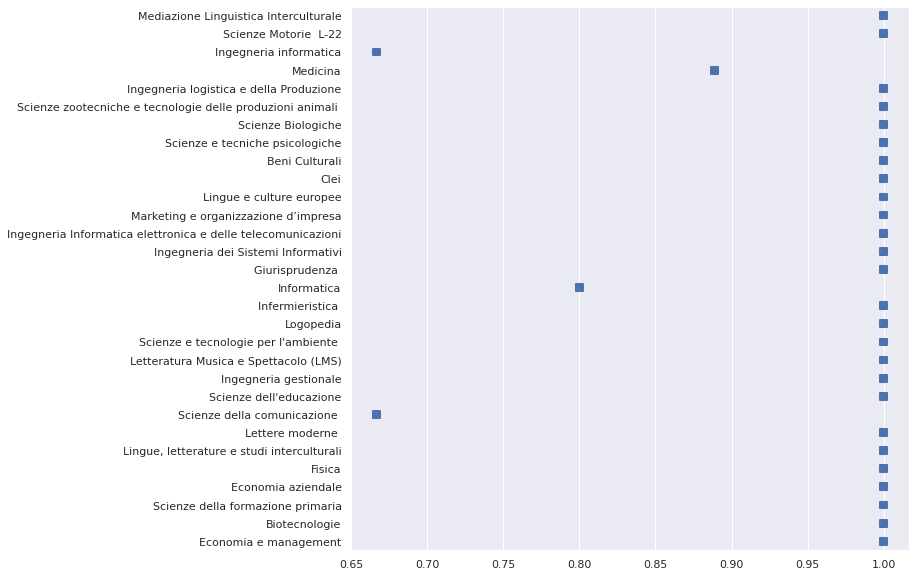

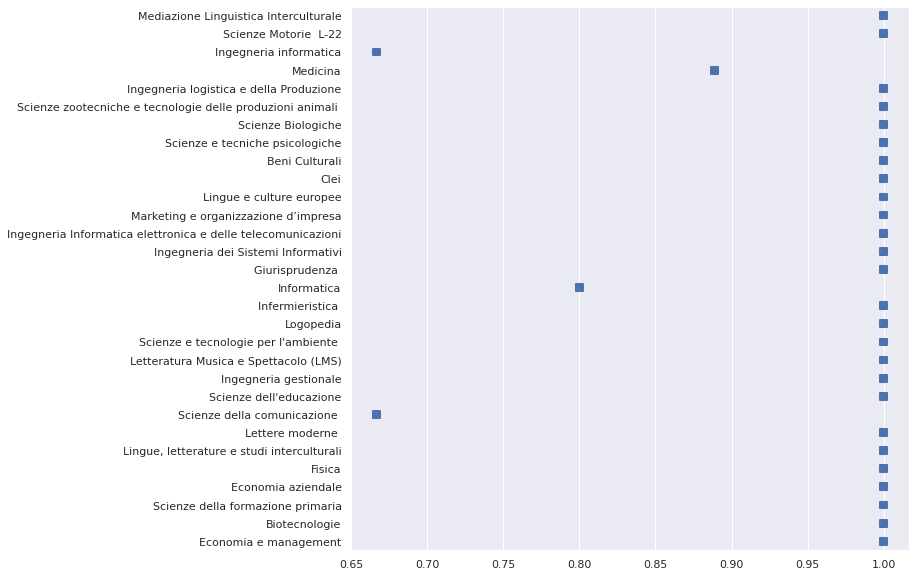

In [ ]:
start=0
end=30
while end <= 120:
  plt.figure(figsize = (10,10))
  sn.set(font_scale=1)
  sn.pointplot( x=report_precision[0:30], y=labels[0:30], markers='s', linestyles='')
  start=end
  end+=30

In [ ]:

cm = confusion_matrix(y_test_list[index], clf.predict(X_test_list[index]))
print("CM per Test set\n", cm)

CM per Test set
 [[ 9  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  8]]


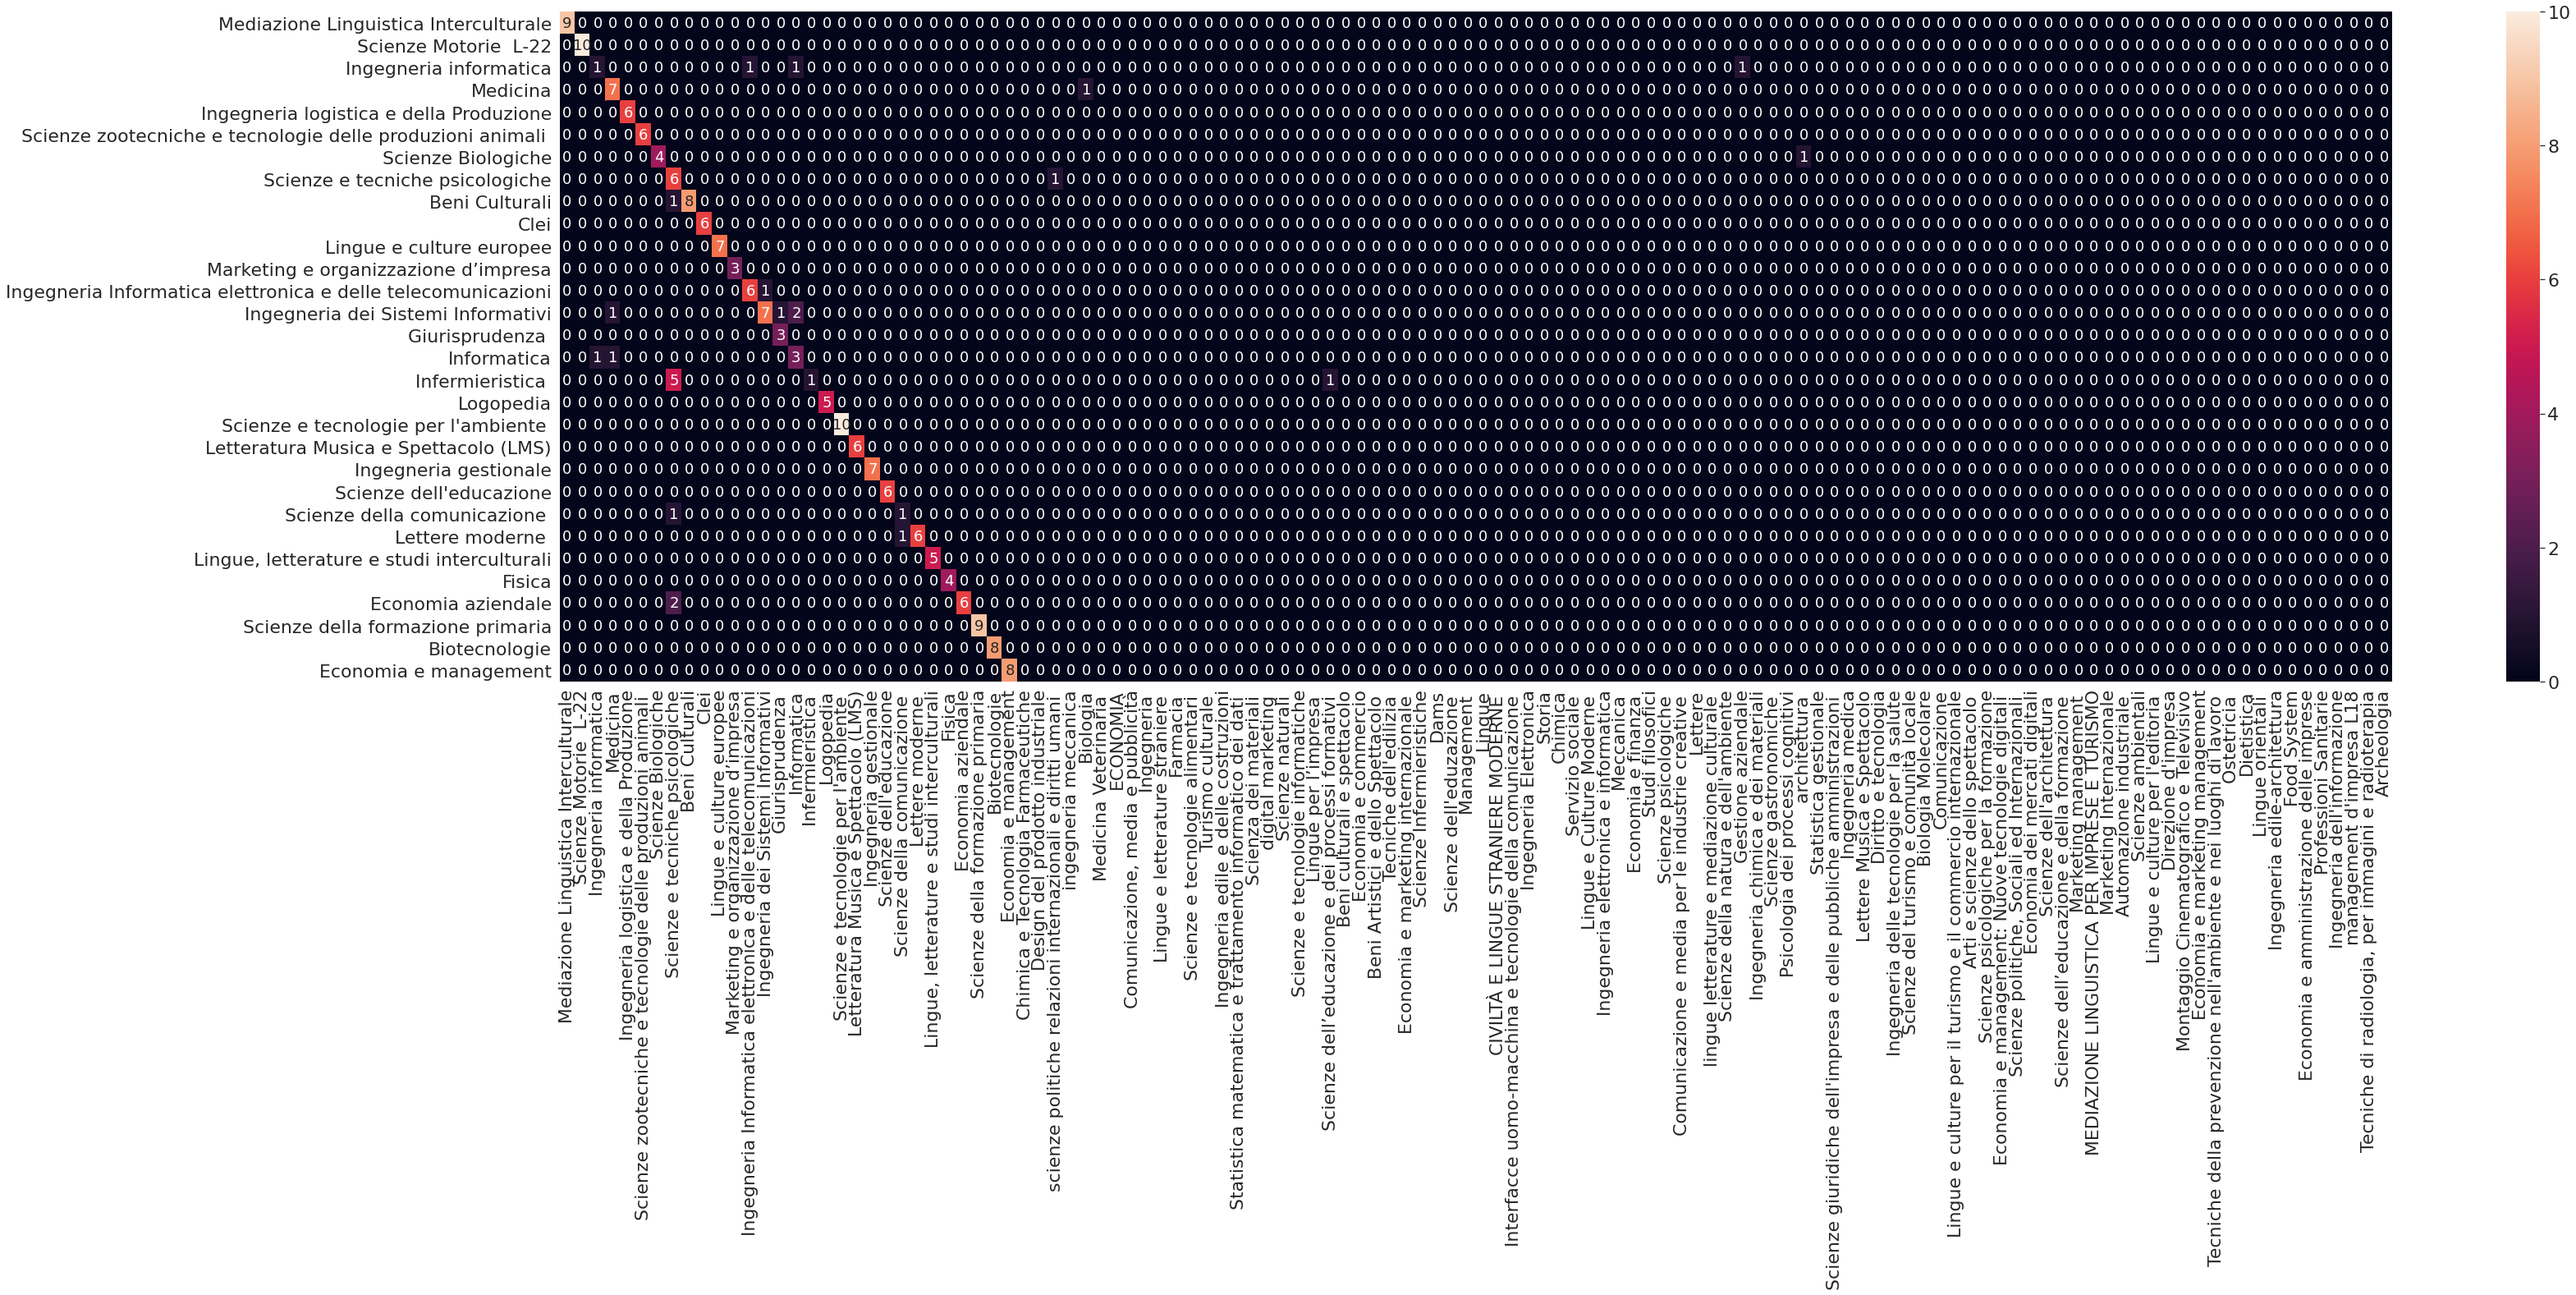

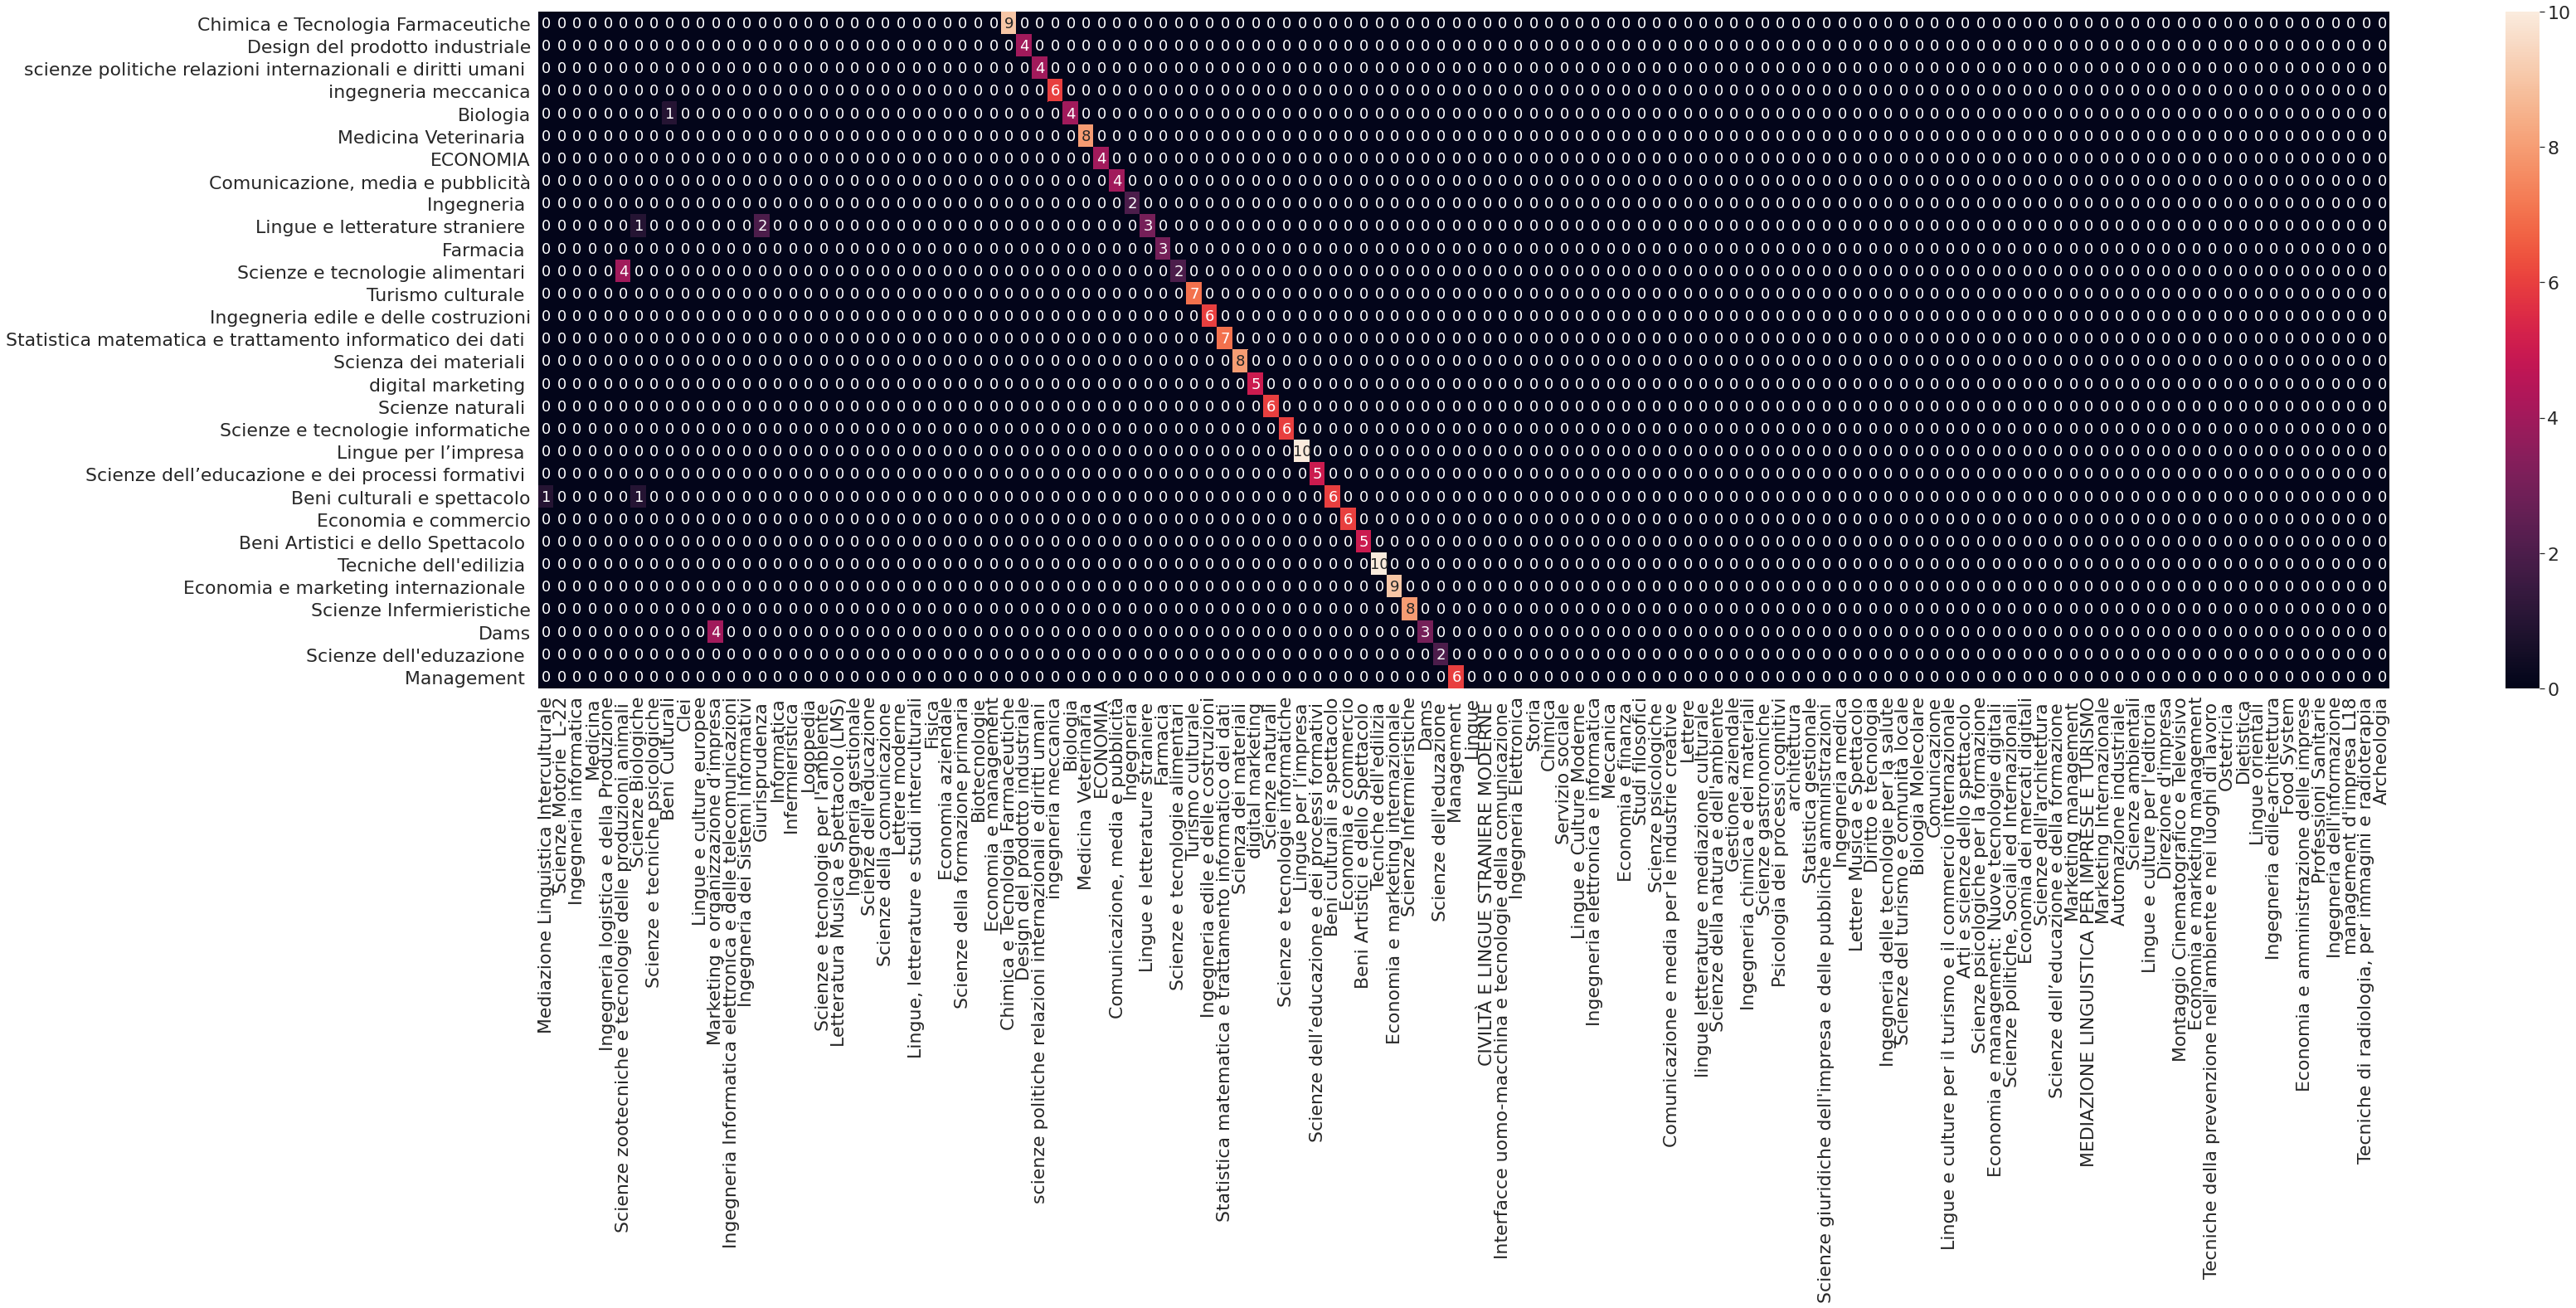

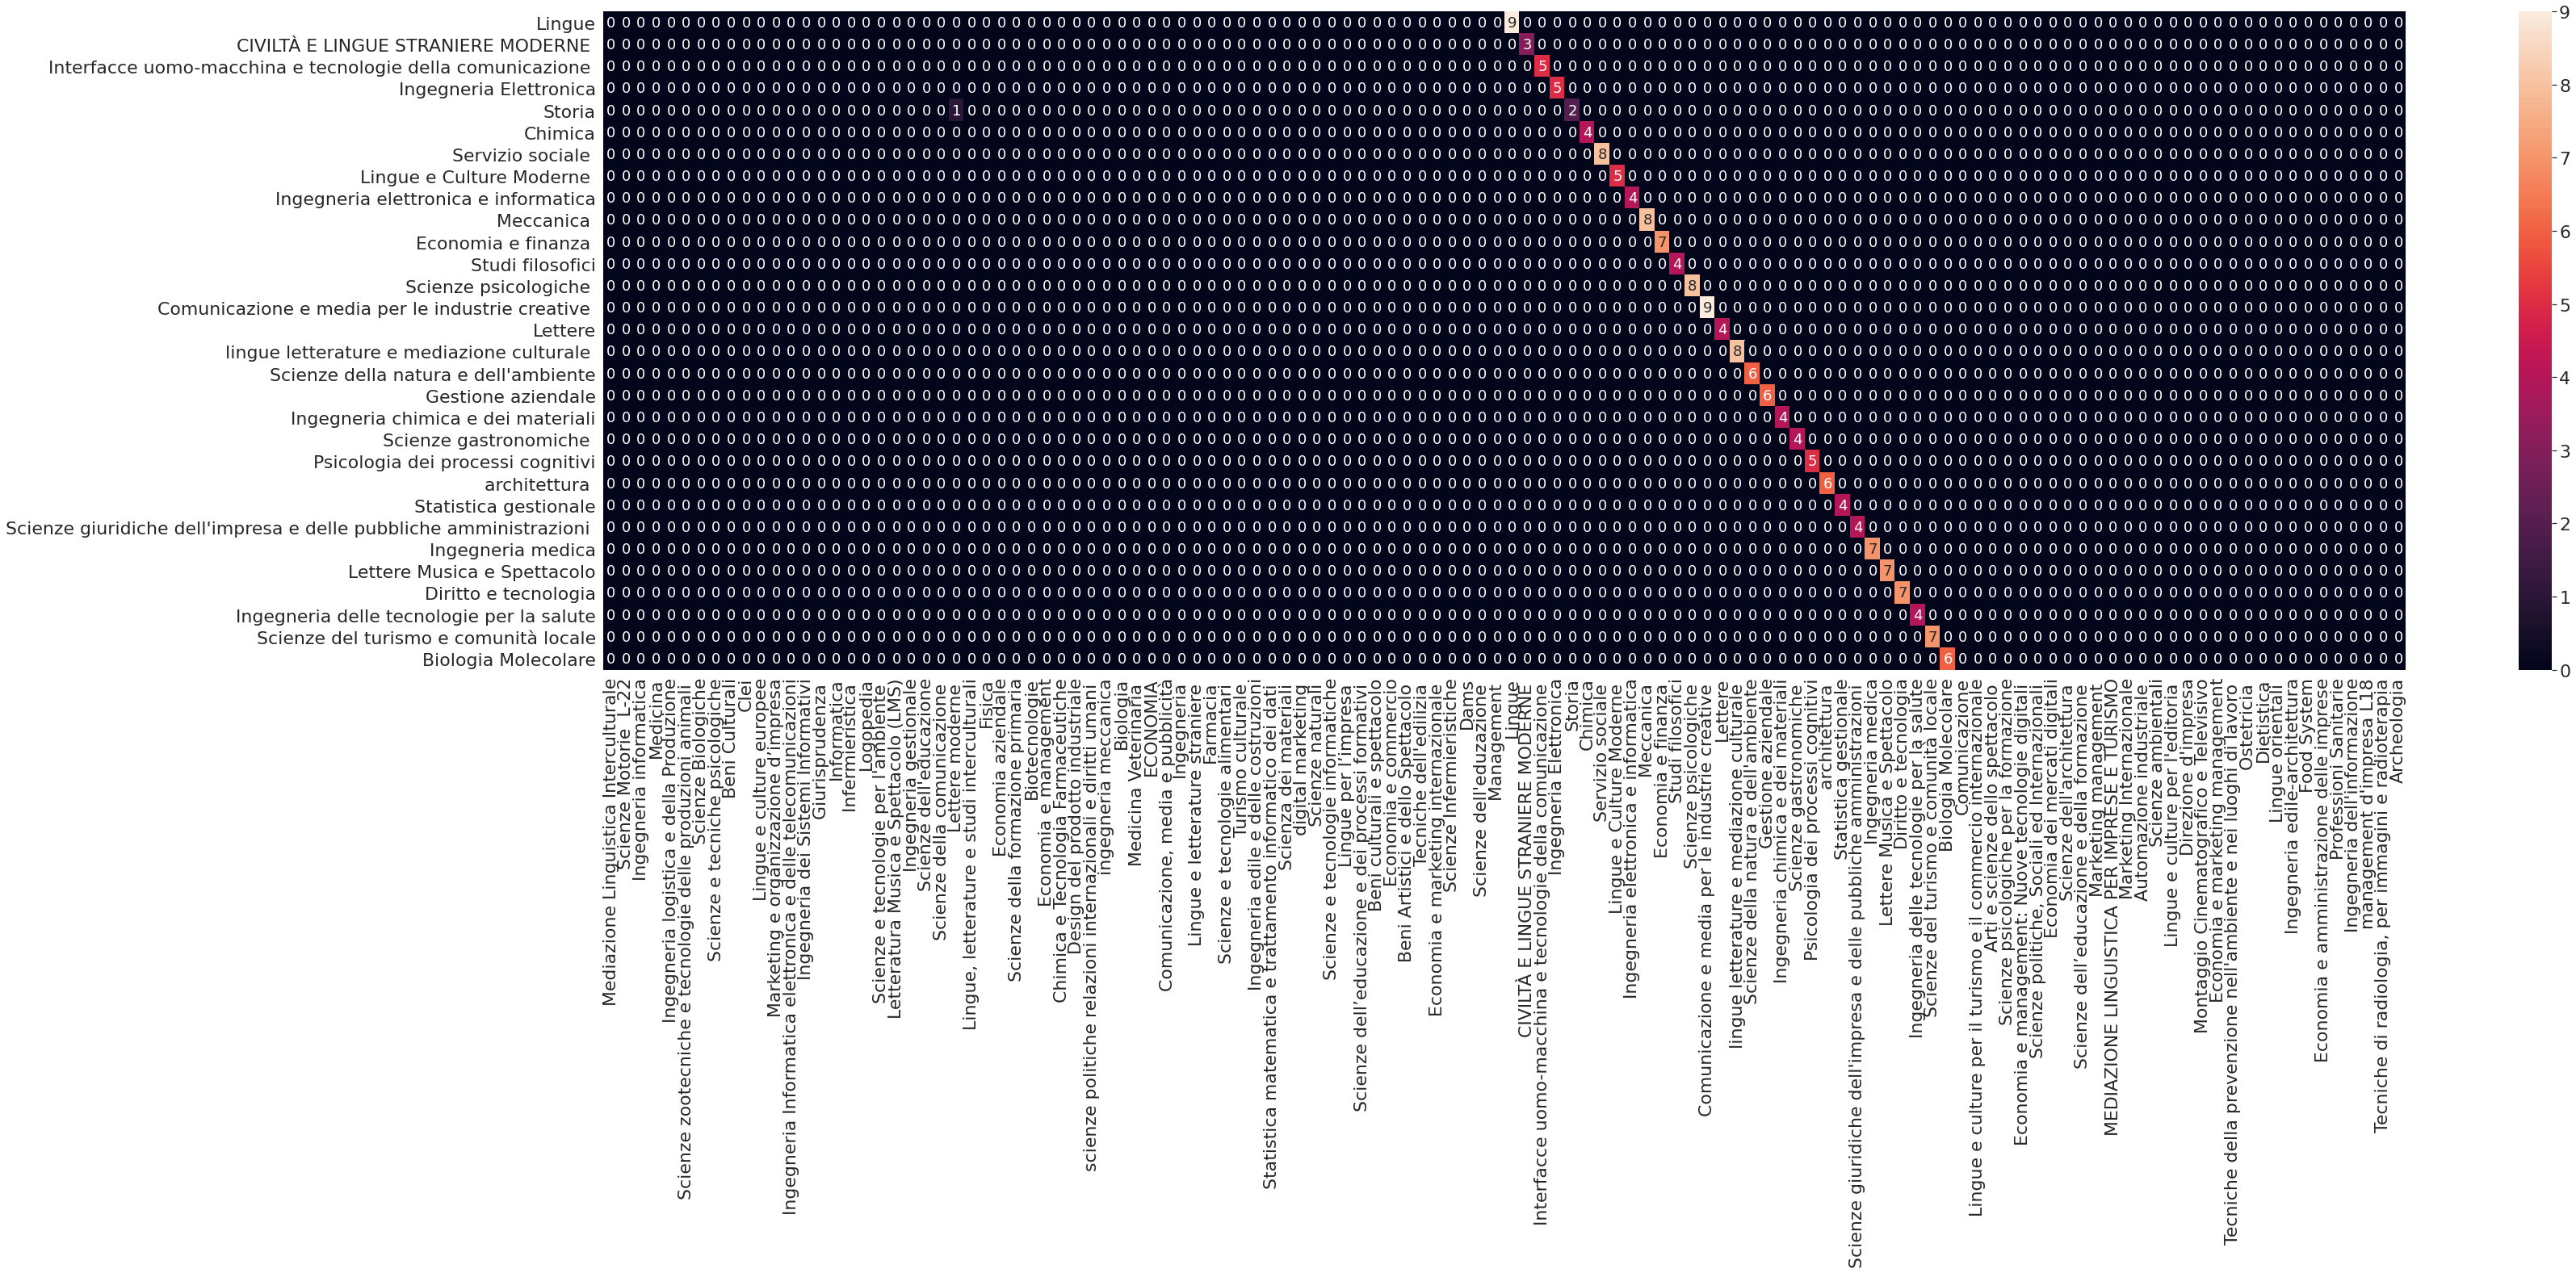

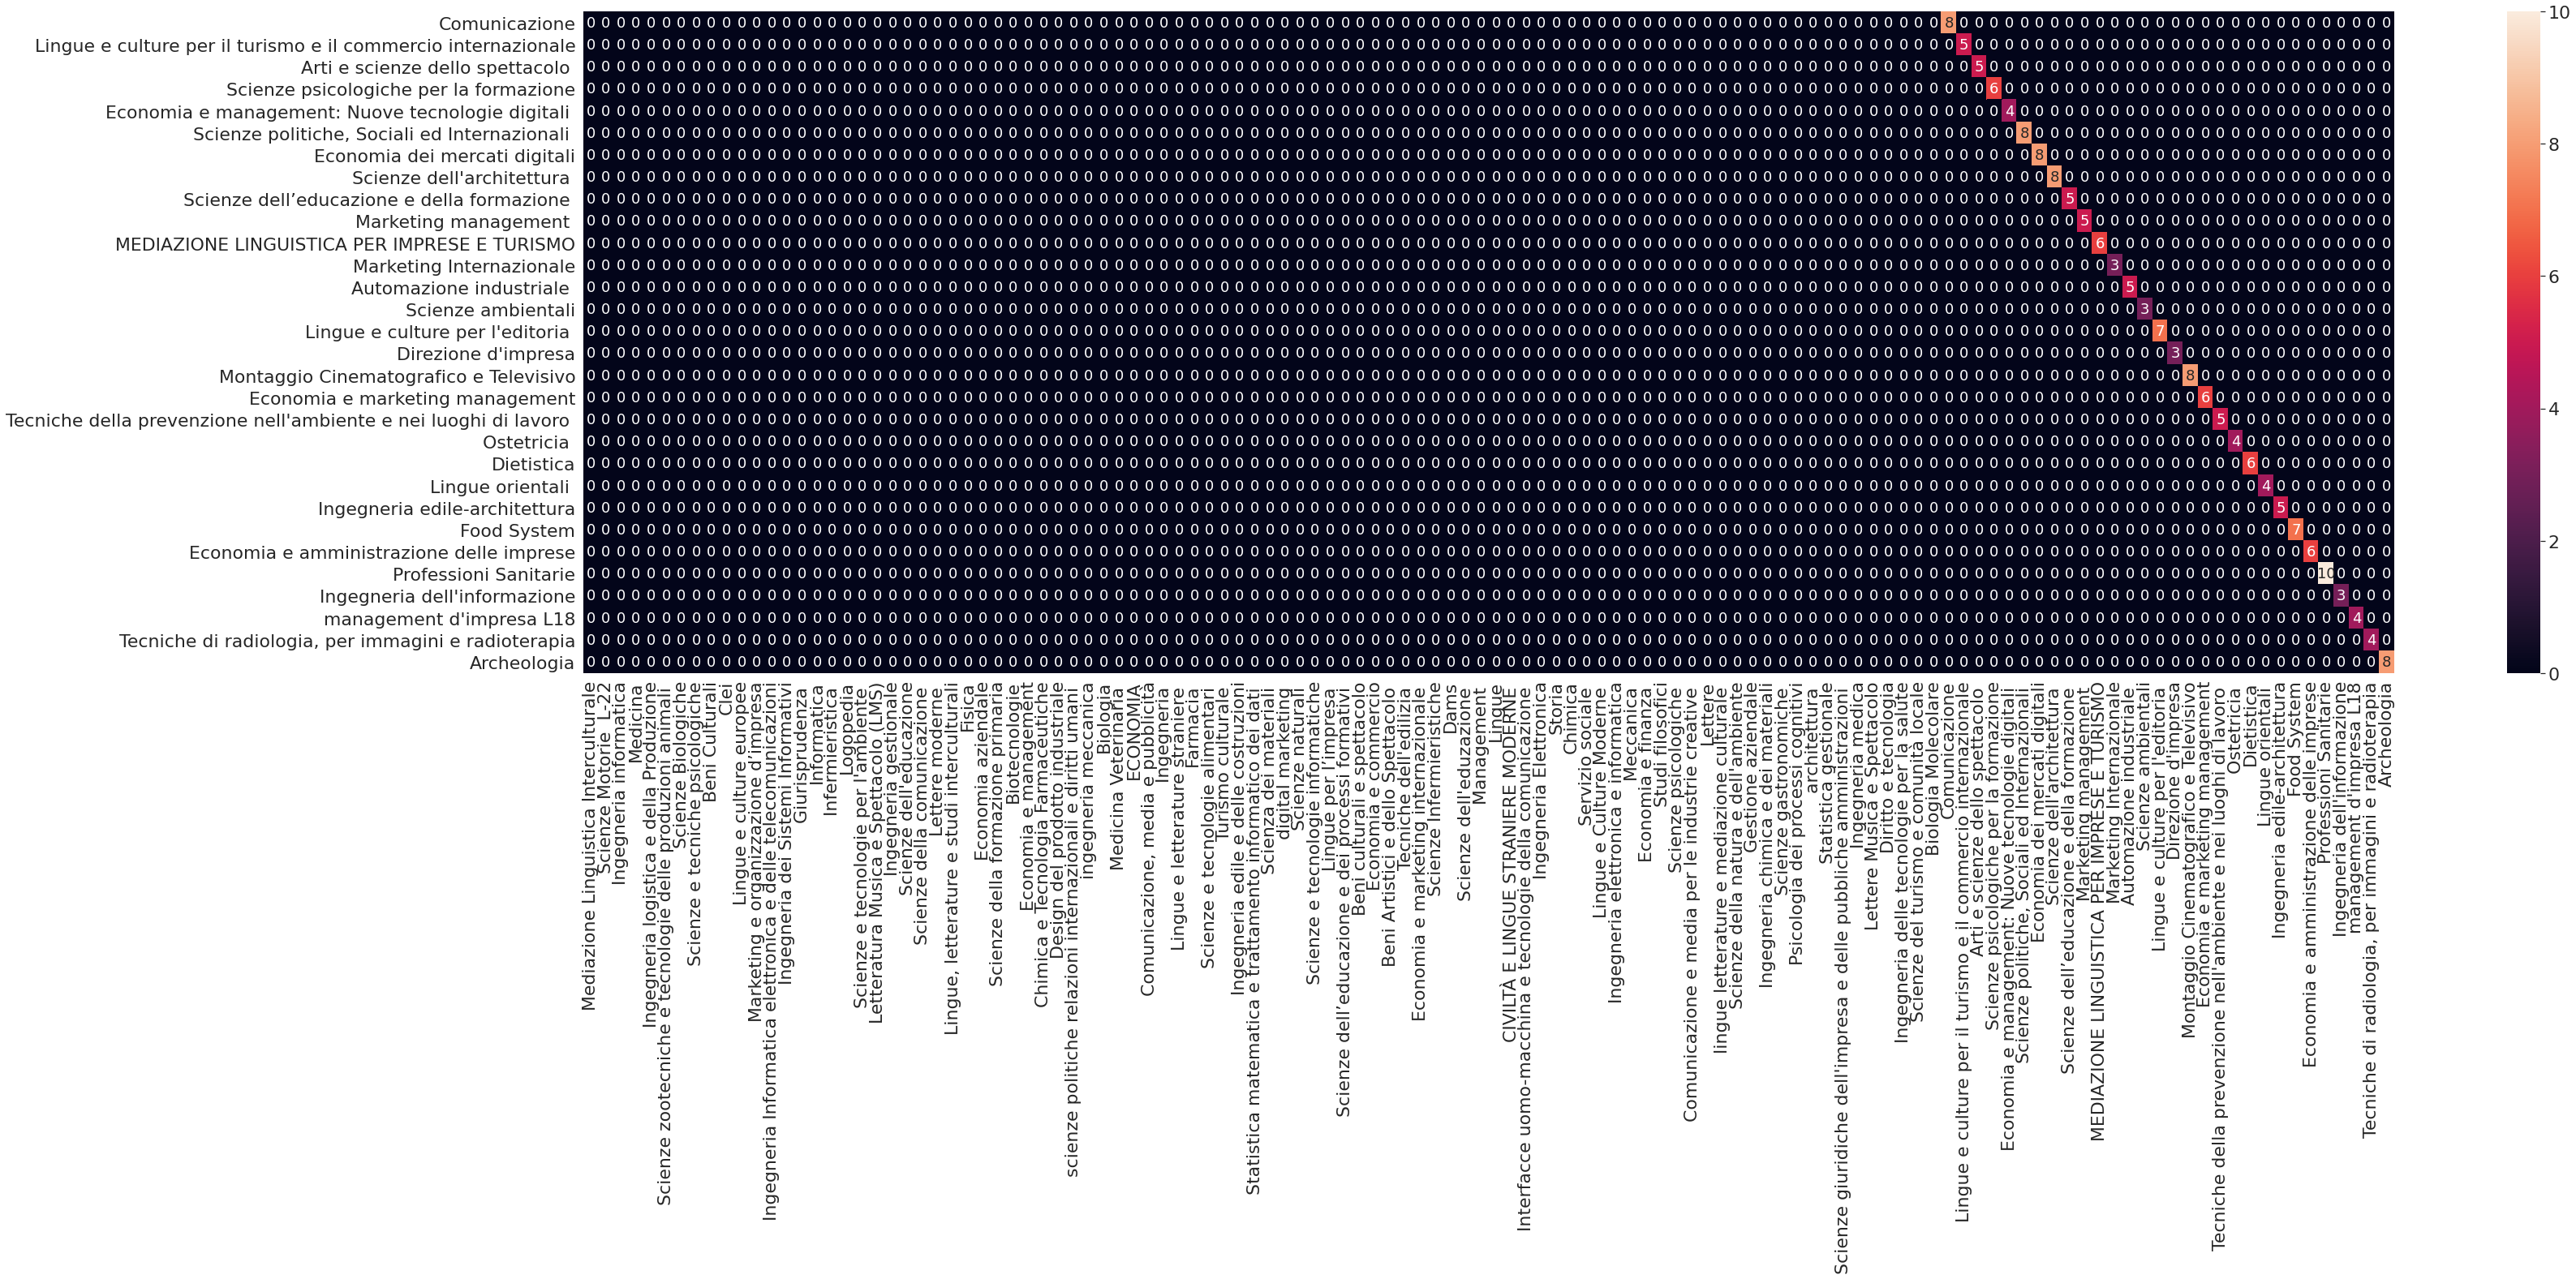

In [ ]:

start=0
end=30
while end <= 120:
  df_cm = pd.DataFrame(cm[start:end, 0:120])
  plt.figure(figsize = (50,15))
  sn.set(font_scale=2)
  sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 18}, xticklabels=labels[0:120], yticklabels=labels[start:end])# font size
  plt.show()
  start=end
  end+=30